# Federated Learning Project (4)


The Project Requirments :
* Implement the F-ML project with Flower framwork.
* Implement the F-ML project with FEDN framwork.
* Use the Following Details:
  - Use the "Shared" VGG16 model.
  - Use FedAvg as a server Aggregation function.
  - 50 Round.
  - The first 5 clients client0-4.
  - use 4 epochs per round.
* Evaluate the model performance by the following metrics:
  - Kappa value.
  - F1 measure.
  - Accuracy.
  - ROC value.
* In a centralized fashion, the 5 client data are used collectively for 50 epochs.
* Plot the model performance in all three Fashions (Centralized, Flower Federated, Flower Fedn )
* Discuss the Graph findings.
* Compare the two frameworks(Flower and FEDN) in terms of their architecture, scalability, and ease of deployment.

### Installing Flower Platfrom dependencies

In [1]:
!pip install -qv flwr[simulation] torch torchvision matplotlib scikit-learn flwr_datasets

Preparing the Data

In [2]:
from google.colab import drive
drive.mount('/content/data', force_remount=True)
directory_path = "/content/data/MyDrive/"
%cd $directory_path

Mounted at /content/data
/content/data/MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/data/', force_remount=True)
directory_path = "/content/data/MyDrive/"
%cd $directory_path

Mounted at /content/data/
/content/data/MyDrive


In [4]:
#directory_path = "/content/data/MyDrive/data"
%ls data


client0/  client1/  client2/  client3/  client4/


### Importing the Needed Libraries

In [5]:
import logging
from PIL import Image
from collections import defaultdict,OrderedDict
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np # to manipulate the passed weights from and to the clients
import torch, pickle, os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from flwr_datasets import FederatedDataset
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score, accuracy_score
from flwr.common import Metrics
import flwr as fl
# Configure logging
#logging.basicConfig(level=logging.DEBUG)
DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.0+cu121 and Flower 1.8.0


Auxiliary Funtions

In [6]:
# Function to load .pyp files
def load_pyp_file(filepath):
    #logging.debug(f"Loading data from {filepath}")
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    #logging.debug(f"Loaded data of type {type(data)} and length {len(data)}")
    return data
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx].argmax().item()

        # Convert the image to PIL Image
        img = Image.fromarray((img * 255).astype(np.uint8))  # Scale to [0, 255] and convert to uint8

        if self.transform:
            img = self.transform(img)

        return {"img": img, "label": label}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Part 1: Centralized Usecase


Global Variables

In [ ]:
#Some global variables
NUM_CLIENTS = 5
BATCH_SIZE = 32

### 1.2. Data loading

Getting the data from the first 5 clients in the centralized location

In [ ]:
def load_aggregated_dataset(data_path):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the tensor
    ])

    all_train_x, all_train_y = [], []
    all_test_x, all_test_y = [], []

    for i in range(NUM_CLIENTS):
        client_path = os.path.join(data_path, f'client{i}')

        train_x = load_pyp_file(os.path.join(client_path, 'trainx.pyp'))
        train_y = load_pyp_file(os.path.join(client_path, 'trainy.pyp'))
        test_x = load_pyp_file(os.path.join(client_path, 'testx.pyp'))
        test_y = load_pyp_file(os.path.join(client_path, 'testy.pyp'))

        all_train_x.extend(train_x)
        all_train_y.extend(train_y)
        all_test_x.extend(test_x)
        all_test_y.extend(test_y)

    train_dataset = CustomImageDataset(np.array(all_train_x), np.array(all_train_y), transform=transform)
    test_dataset = CustomImageDataset(np.array(all_test_x), np.array(all_test_y), transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, testloader

# Load the centralized dataset
data_path = './data'
centralized_trainloader, centralized_testloader = load_aggregated_dataset(data_path)


### 1.3 Data Visualization

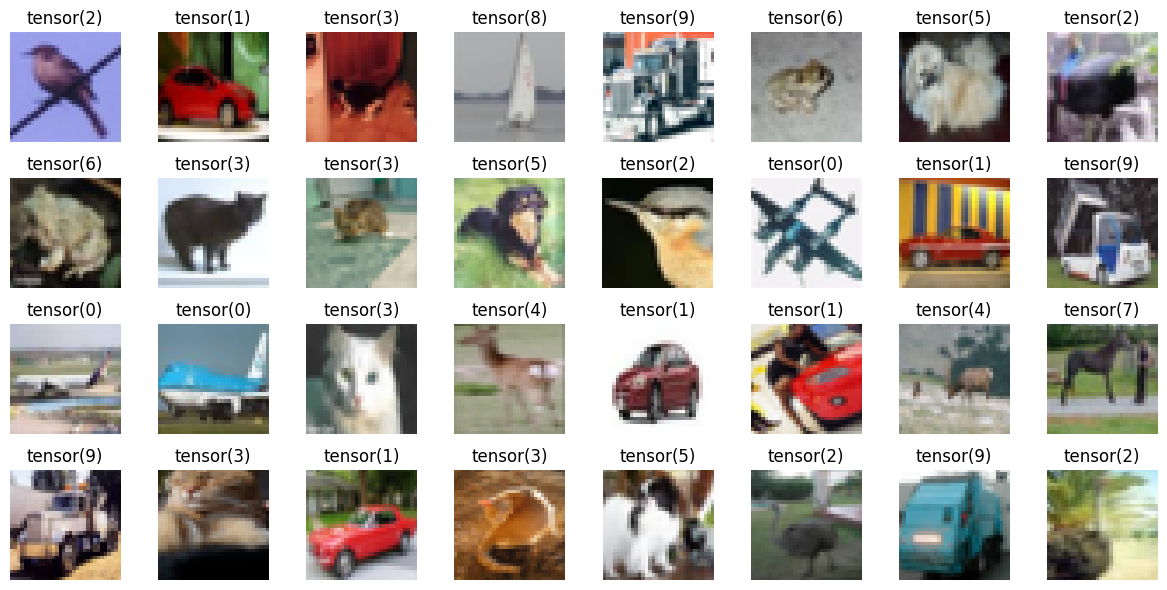

In [ ]:

batch = next(iter(centralized_trainloader))
images, labels = batch["img"], batch["label"]
images = images.permute(0, 2, 3, 1).numpy()
images = images * 0.5 + 0.5
images = np.clip(images, 0, 1)
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    if i < len(images):  # Ensure we don't go out of bounds
        ax.imshow(images[i])
        # For one-hot encoded labels, get the index of the max value
        label = labels[i]
        ax.set_title(str(label))
        ax.axis("off")
    else:
        ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


### 1.4. Model Definition

Customed Shared VGG Model

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.avgpool = nn.AvgPool2d(kernel_size=1, stride=1)
        self.classifier = nn.Linear(512, 10) # we have 10 classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

def create_model():
    return VGG('VGG16')



Define the Train Funtion :

In [ ]:
def center_train(net, trainloader,  epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())  # Used for backpropagation to enhance the model accuracy
    net.train()
    metrics = {
        "loss": [],
        "accuracy": [],
        "kappa": [],
        "f1": [],
        "roc_auc": []
    }

    for epoch in range(epochs):
        epoch_loss, correct, total = 0.0, 0, 0
        predictions, targets, probas = [], [], []
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            predicted = torch.max(outputs, 1)[1]
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            probas.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        kappa = cohen_kappa_score(targets, predictions)
        f1 = f1_score(targets, predictions, average='weighted')
        roc_auc = roc_auc_score(targets, probas, multi_class='ovr')
        #accuracy = accuracy_score(targets, predictions)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}, kappa {kappa}, f1 {f1}, roc_auc {roc_auc}")
        metrics["loss"].append(epoch_loss)
        metrics["accuracy"].append(epoch_acc)
        metrics["kappa"].append(kappa)
        metrics["f1"].append(f1)
        metrics["roc_auc"].append(roc_auc)
    #print(f"Length of loss metrics: {len(metrics['loss'])}")
    #print(f"Length of accuracy metrics: {len(metrics['accuracy'])}")
    #print(f"Length of kappa metrics: {len(metrics['kappa'])}")
    #print(f"Length of f1 metrics: {len(metrics['f1'])}")
    #print(f"Length of roc_auc metrics: {len(metrics['roc_auc'])}")
    return metrics


The Test Funtion :

In [ ]:
def center_test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    predictions, targets, probas = [], [], []
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            probas.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    kappa = cohen_kappa_score(targets, predictions)
    f1 = f1_score(targets, predictions, average='weighted')
    roc_auc = roc_auc_score(targets, probas, multi_class='ovr')
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "kappa": kappa,
        "f1": f1,
        "roc_auc": roc_auc
    }
    return metrics

### 1.5 Run Centralized Model and view results

Epoch 1: train loss 0.059629793672561646, accuracy 0.26184, kappa 0.17968439169996164, f1 0.25797046749106123, roc_auc 0.7652479582183538
Epoch 2: train loss 0.0479402231836319, accuracy 0.42696, kappa 0.363274911499746, f1 0.42376751284482295, roc_auc 0.8571485239371702
Epoch 3: train loss 0.040546121015548706, accuracy 0.52568, kappa 0.47294328156418497, f1 0.5223402980275907, roc_auc 0.8986916235281128
Epoch 4: train loss 0.03555204297065735, accuracy 0.59536, kappa 0.5503783478198857, f1 0.5935900294759691, roc_auc 0.9207517218648033
Epoch 5: train loss 0.03121286941051483, accuracy 0.64664, kappa 0.6073603243334216, f1 0.6467736732296692, roc_auc 0.9374180628549947
Epoch 6: train loss 0.02779449221611023, accuracy 0.68912, kappa 0.6545541978008511, f1 0.6888786064436683, roc_auc 0.9496555422288893
Epoch 7: train loss 0.024545115256309508, accuracy 0.72632, kappa 0.6958921023401214, f1 0.7266602711637025, roc_auc 0.959736731697158
Epoch 8: train loss 0.02194277493238449, accuracy 0

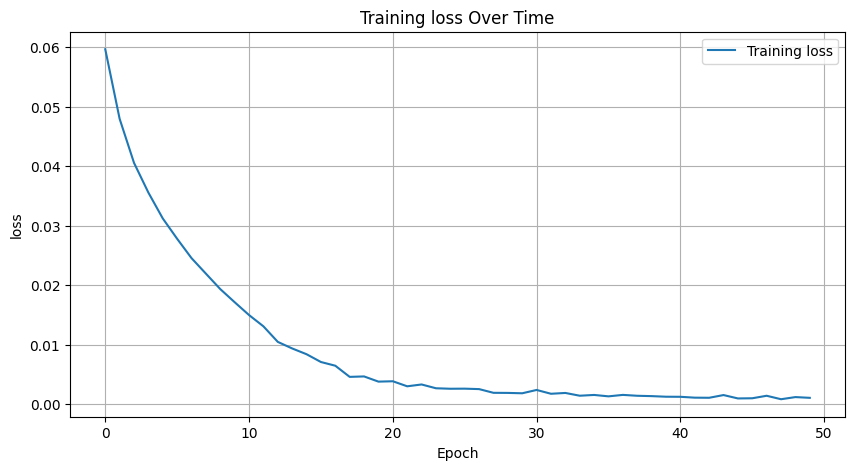

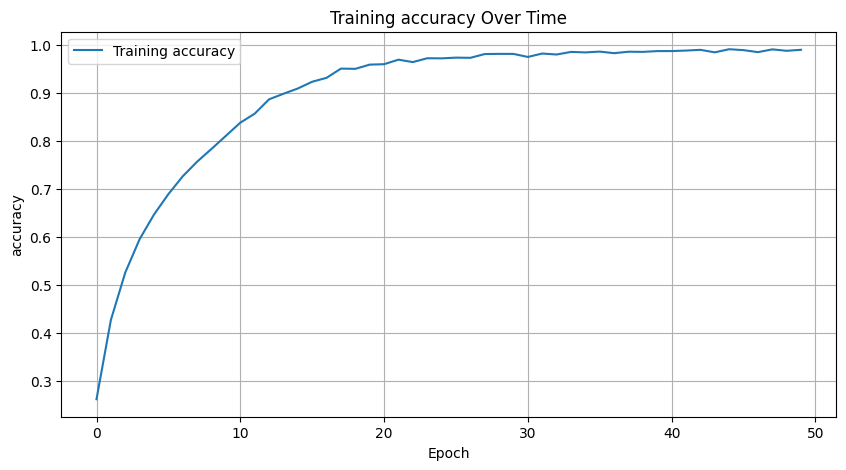

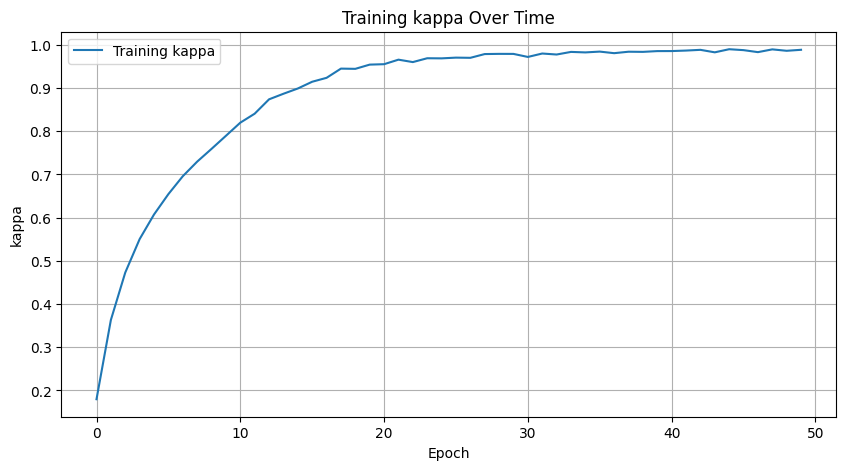

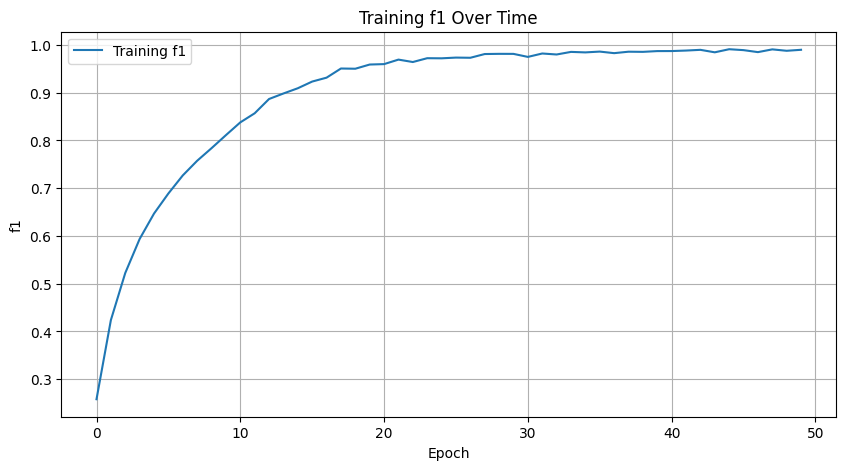

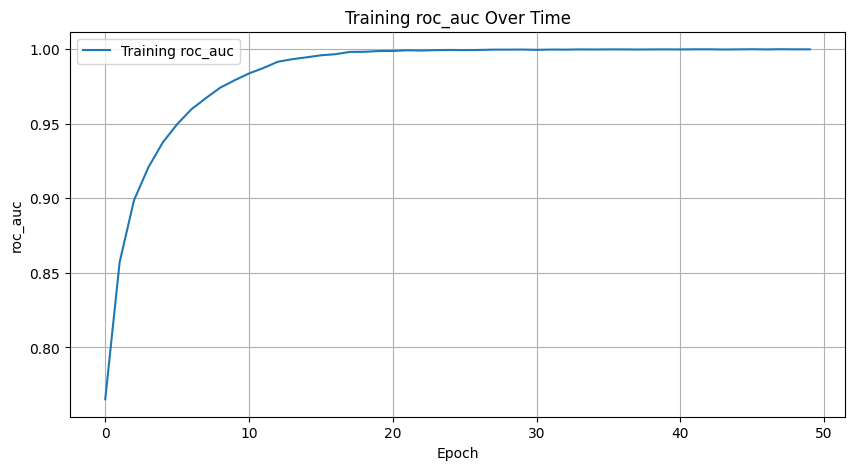

Test Metrics: Loss: 0.04234445412158966, Accuracy: 0.7416, Kappa: 0.7128716356645075, F1: 0.7415070706956991, ROC AUC: 0.9583801286488102


In [ ]:
# Load the centralized dataset
data_path = './data'
centralized_trainloader, centralized_testloader = load_aggregated_dataset(data_path)

# Initialize the model
model = create_model().to(DEVICE)

# Train the model
epochs = 50

train_metrics = center_train(model, centralized_trainloader, epochs, verbose=True)
print(f"Final Training Metrics: Loss: {train_metrics['loss'][-1]}, Accuracy: {train_metrics['accuracy'][-1]}, Kappa: {train_metrics['kappa'][-1]}, F1: {train_metrics['f1'][-1]}, ROC AUC: {train_metrics['roc_auc'][-1]}")
def plot_metrics(metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics[metric_name], label=f'Training {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Training {metric_name} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the training metrics
plot_metrics(train_metrics, "loss")
plot_metrics(train_metrics, "accuracy")
plot_metrics(train_metrics, "kappa")
plot_metrics(train_metrics, "f1")
plot_metrics(train_metrics, "roc_auc")
# Test the model
test_metrics = center_test(model, centralized_testloader)
print(f"Test Metrics: Loss: {test_metrics['loss']}, Accuracy: {test_metrics['accuracy']}, Kappa: {test_metrics['kappa']}, F1: {test_metrics['f1']}, ROC AUC: {test_metrics['roc_auc']}")

## Part 2: "TrustWorthy Environment with decenteralized and client Evaluation" Flower federated Usecase with :
  - Use the "Shared" VGG16 model.
  - Use FedAvg as a server Aggregation function.
  - 50 Round.
  - The first 5 clients client0-4.
  - use 4 epochs per round.

Set the Global Variabel

In [7]:
NUM_CLIENTS = 5
BATCH_SIZE = 32

### 2.1. Federated Language Data Access:

as the data is already distributed across the Client nodes, then we don't need to prepare it serverside.

In [8]:
def load_dataset(data_path,clientId):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the tensor
    ])

    train_x, train_y = [], []
    test_x, test_y = [], []
    client_path = os.path.join(data_path, f'client{clientId}')
    train_x = load_pyp_file(os.path.join(client_path, 'trainx.pyp'))
    train_y = load_pyp_file(os.path.join(client_path, 'trainy.pyp'))
    test_x = load_pyp_file(os.path.join(client_path, 'testx.pyp'))
    test_y = load_pyp_file(os.path.join(client_path, 'testy.pyp'))

    train_dataset = CustomImageDataset(np.array(train_x), np.array(train_y), transform=transform)
    test_dataset = CustomImageDataset(np.array(test_x), np.array(test_y), transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, testloader


### 2.2. instantiate a model

In [9]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.avgpool = nn.AvgPool2d(kernel_size=1, stride=1)
        self.classifier = nn.Linear(512, 10) # we have 10 classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

def create_model():
    return VGG('VGG16')


Building the server side toolbox

In [10]:
class NeuralNetworkManager:
    @staticmethod
    def get_parameters(net) -> List[np.ndarray]:
        params = [val.cpu().numpy() for _, val in net.state_dict().items()]
        return params

    @staticmethod
    def set_parameters(net, parameters: List[np.ndarray]):
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k:torch.Tensor(v) for k, v in params_dict if len(v.shape) > 0})
        net.load_state_dict(state_dict, strict=False)
        return net

    @staticmethod
    def train(net, trainloader, epochs: int, verbose=True):
        """Train the network on the training set."""
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters()) # the optimizer could be adam
        net.train()
        for epoch in range(epochs):
            correct, total, epoch_loss = 0, 0, 0.0
            for batch in trainloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Metrics
                epoch_loss += loss
                total += labels.size(0)
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            epoch_loss /= len(trainloader.dataset)
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    @staticmethod
    def test(net, testloader):
        """Evaluate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        correct, total, loss = 0, 0, 0.0
        net.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                outputs = net(images)
                batch_loss= criterion(outputs, labels).item()
                loss +=batch_loss
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                print(f"Batch Loss: {batch_loss}")
                print(f"Batch Predictions: {predicted.cpu().numpy()}")
                print(f"Batch True Labels: {labels.cpu().numpy()}")
                print(f"Batch Correct Predictions: {(predicted == labels).sum().item()}")

        loss /= len(testloader)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        kappa = cohen_kappa_score(all_labels, all_preds)
        # Check if there are at least two classes
        unique_labels = set(all_labels)
        print(f"Unique Labels: {unique_labels}")
        if len(unique_labels) > 1:
          try:
            roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
          except ValueError:
            roc_auc = np.nan
        else:
          print("ROC AUC cannot be computed with less than 2 classes.")
          roc_auc = np.nan

        metrics = {"accuracy": accuracy, "f1": f1, "kappa": kappa, "roc_auc": roc_auc}
        #print(f"Final Loss: {loss}")
        #print(f"Accuracy: {accuracy}")
        #print(f"F1 Score: {f1}")
        #print(f"Cohen's Kappa: {kappa}")
        #print(f"ROC AUC: {roc_auc}")
        return loss, metrics

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracy = [m["accuracy"] for _, m in metrics]
    f1= [m["f1"] for _, m in metrics]
    kappa= [m["kappa"] for _, m in metrics]
    roc_auc= [m["roc_auc"] for _, m in metrics]

    # Aggregate and return custom metric (weighted average)
    return {'accuracy':np.mean(accuracy),'f1':np.mean(f1),'kappa':np.mean(kappa),'roc_auc':np.mean(roc_auc)}

### 2.3.Federating the FlowerClient

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, manager=NeuralNetworkManager):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.manager = manager

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.manager.get_parameters(self.net)

    def fit(self, parameters, config):
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        self.manager.train(self.net, self.trainloader, epochs=local_epochs)
        return self.manager.get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        loss, metrics = self.manager.test(self.net, self.valloader)
        #if config["save_model_instruction"]:
            #save model
        #    torch.save(self.net, "weights.dat")
        #print(loss)
        #print(len(self.valloader.dataset))
        #print(metrics)
        # Return only the necessary values for Flower

        return float(loss), len(self.valloader.dataset), metrics #

Construct the clients Configuration File

In [12]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 4 #if server_round < 2 else 3,
        #"save_model_instruction": False if server_round < 2 else True
    }
    return config

In [13]:
def client_fn(cid) -> FlowerClient:
    net = VGG('VGG16').to(DEVICE)
    #net = FrozenNet().to(DEVICE)
    #trainloader = trainloaders[int(cid)]
    #valloader = valloaders[int(cid)]
    data_path = './data'
    trainloader, valloader = load_dataset(data_path,int(cid))
    return FlowerClient(cid, net, trainloader, valloader).to_client()

Set the Stratigy with FedAvg with random model parameter initialization

In [17]:
# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
    #initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
    #evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}



Extending the FedAvg to calculate the avarage of the round performance metrics

### 2.4.Start Simulation and Plot

In [18]:
# Final
# Start simulation

history=fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),# Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)


INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-09 08:29:12,486	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 8.0, 'object_store_memory': 16176006758.0, 'memory': 32352013518.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 8.0, 'object_store_memory': 16176006758.0, 'memory': 32352013518.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimi

(ClientAppActor pid=26380) [Client 4] get_parameters
(ClientAppActor pid=26380) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 4}
(ClientAppActor pid=26380) Epoch 1: train loss 0.0633145347237587, accuracy 0.2644
(ClientAppActor pid=26380) Epoch 2: train loss 0.04936804622411728, accuracy 0.4476
(ClientAppActor pid=26380) Epoch 3: train loss 0.040181104093790054, accuracy 0.5844
(ClientAppActor pid=26380) Epoch 4: train loss 0.030812306329607964, accuracy 0.7256
(ClientAppActor pid=26380) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 4}
(ClientAppActor pid=26380) Epoch 1: train loss 0.06414569169282913, accuracy 0.2556
(ClientAppActor pid=26380) Epoch 2: train loss 0.05058325082063675, accuracy 0.4348
(ClientAppActor pid=26380) Epoch 3: train loss 0.03951137140393257, accuracy 0.6008
(ClientAppActor pid=26380) Epoch 4: train loss 0.030761582776904106, accuracy 0.7288
(ClientAppActor pid=26380) [Client 2, round 1] fit, config: {'server_round'

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.030699318274855614, accuracy 0.7224


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7866506576538086
(ClientAppActor pid=26380) Batch Predictions: [7 8 3 4 9 4 4 8 9 4 3 5 4 8 6 3 3 4 8 2 0 4 4 4 1 0 4 8 8 8 6 3]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 11
(ClientAppActor pid=26380) Batch Loss: 1.799910545349121
(ClientAppActor pid=26380) Batch Predictions: [5 2 4 4 0 8 8 2 3 7 5 2 0 8 4 8 7 4 0 0 8 8 9 6 5 4 4 0 4 8 7 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 8
(ClientAppActor pid=26380) Batch Loss: 1.5312230587005615
(ClientAppActor pid=26380) Batch Predictions: [4 8 4 4 3 5 4 6 9 2 4 8 6 3 4 0 4 8 6 4 0 1 9 4 8 8 8 4 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.8777424097061157
(ClientAppActor pid=26380) Batch Predictions: [4 5 3 4 4 3 8 0 6 2 4 6 3 4 6 5 4 8 3 4 4 6 6 4 7 4 6 2 8 4 6 4]
(ClientAppActor pid=26380) Batch True Labels: [7 5 5 2 5 6 2 0 4 7 3 6 4 5 3 5 6 4 3 2 2 6 6 5 3 5 2 5 8 7 6 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 9
(ClientAppActor pid=26380) Batch Loss: 1.748742938041687
(ClientAppActor pid=26380) Batch Predictions: [4 4 6 8 4 6 4 6 2 4 0 4 8 9 1 6 9 8 3 3 9 8 4 6 0 8 3 2 4 4 4 3]
(ClientAppActor pid=26380) Batch True Labels: [0 3 6 0 4 5 7 6 2 8 2 4 9 9 1 2 9 8 7 2 9 8 2 6 9 0 3 2 7 6 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 14
(ClientAppActor pid=26380) Batch Loss: 1.7964539527893066
(ClientAppActor pid=26380) Batch Predictions: [0 8 1 4 3 5 4 4 8 3 4 3 4 4 8 4 4 8 6 4 4 8 4 6 8 7 4 6 4 5 4 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct P

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.01830662414431572, accuracy 0.8716


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.8188122510910034
(ClientAppActor pid=26380) Batch Predictions: [4 2 5 9 6 7 2 9 8 7 0 4 6 7 2 9 4 1 9 9 4 4 0 5 3 0 4 6 0 2 9 6]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 9
(ClientAppActor pid=26380) Batch Loss: 1.7811123132705688
(ClientAppActor pid=26380) Batch Predictions: [9 3 0 6 4 8 9 4 0 4 2 7 4 5 3 9 5 7 9 9 5 9 0 6 1 0 6 6 0 3 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 12
(ClientAppActor pid=26380) Batch Loss: 1.6326262950897217
(ClientAppActor pid=26380) Batch Predictions: [6 6 9 4 6 7 5 2 4 9 7 0 6 8 3 4 4 9 8 6 2 9 6 2 5 5 9 6 8 8 4 9]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.3813332319259644
(ClientAppActor pid=26380) Batch Predictions: [6 4 4 7 0 6 2 9 6 5 0 4 6 8 3 6 6 8 9 1 6 6 7 4 6 3 4 4 6 1 1 9]
(ClientAppActor pid=26380) Batch True Labels: [3 3 4 7 0 6 6 1 6 7 0 4 6 8 3 2 4 8 1 1 0 6 4 7 9 6 6 6 6 1 8 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.5903470516204834
(ClientAppActor pid=26380) Batch Predictions: [6 8 4 2 9 5 9 6 6 4 9 3 8 7 2 9 9 9 6 4 0 8 2 6 0 4 9 3 6 7 7 8]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 1.622961401939392
(ClientAppActor pid=26380) Batch Predictions: [0 4 9 6 8 3 4 1 2 6 6 3 3 4 0 7 8 6 6 4 5 2 7 2 9 6 6 6 0 6 7 8]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.008042576722800732, accuracy 0.9652


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.8014194965362549
(ClientAppActor pid=26380) Batch Predictions: [4 2 5 1 7 5 2 8 8 0 8 4 6 3 2 6 2 1 2 6 5 4 0 5 3 0 4 3 0 3 6 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 12
(ClientAppActor pid=26380) Batch Loss: 1.5818020105361938
(ClientAppActor pid=26380) Batch Predictions: [1 3 2 6 4 0 9 3 0 3 2 7 4 5 3 9 5 7 1 9 5 9 0 6 1 0 6 3 0 5 8 1]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.3560056686401367
(ClientAppActor pid=26380) Batch Predictions: [2 6 9 4 6 7 5 0 3 9 7 0 2 8 5 4 5 8 8 6 4 8 1 2 5 5 8 1 8 5 4 0]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.382192611694336
(ClientAppActor pid=26380) Batch Predictions: [4 3 4 7 0 6 4 1 6 5 0 4 6 8 2 6 2 8 8 1 6 6 3 4 6 3 6 4 6 1 1 0]
(ClientAppActor pid=26380) Batch True Labels: [3 3 4 7 0 6 6 1 6 7 0 4 6 8 3 2 4 8 1 1 0 6 4 7 9 6 6 6 6 1 8 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.2620753049850464
(ClientAppActor pid=26380) Batch Predictions: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 2 9 6 2 6 4 6 8 3 6 0 4 8 3 6 5 7 0]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.5608375072479248
(ClientAppActor pid=26380) Batch Predictions: [0 6 1 6 8 8 5 1 3 6 2 3 3 7 0 7 5 1 6 4 5 2 7 2 9 6 1 6 0 4 3 8]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.004901088774204254, accuracy 0.9836


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.6552238464355469
(ClientAppActor pid=26380) Batch Predictions: [9 3 6 2 0 2 1 0 4 4 3 3 7 3 7 0 4 0 9 0 7 6 1 4 0 9 3 1 5 7 4 4]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.1016912460327148
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 7 0 6 6 2 6 3 6 9 9 9 7 8 9 8 6 1 7 5 0 8 8 9 6 3 5 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.1893168687820435
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 8 6 7 7 4 5 4 2 4 4 4 7 1 3 6 1 5 6 8 7 5 1 2 8 0 9 3 7 4]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.287279486656189
(ClientAppActor pid=26380) Batch Predictions: [0 6 0 6 4 5 1 9 5 8 4 7 5 0 0 8 1 8 6 6 7 1 0 4 8 1 9 1 2 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.3103184700012207
(ClientAppActor pid=26380) Batch Predictions: [3 6 9 7 8 1 5 5 8 4 4 5 3 1 2 3 6 8 3 5 6 8 8 8 8 6 0 4 8 0 2 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 0.873917818069458
(ClientAppActor pid=26380) Batch Predictions: [8 4 0 6 6 8 9 9 4 5 7 9 3 2 3 1 8 0 4 5 6 8 2 3 5 5 8 3 8 3 5 5]
(ClientAppActor pid=26380) Batch True Labels: [8 7 0 6 6 3 9 9 2 3 7 9 5 0 5 1 8 0 4 7 6 8 2 1 5 5 8 5 8 4 7 2]
(ClientAppActor pid=26380) Batch Correct P

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.00374803994782269, accuracy 0.9848


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.4659476280212402
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 1 7 6 6 1 4 6 9 7 1 8 2 4 6 7 8 3 5 4 9 3 8 4 4 9 3 6]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.055235743522644
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 8 1 9 8 0 8 9 7 1 2 5 9 6 2 1 5 1 6 6]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 0.9502543807029724
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 0 2 0 8 8 9 7 3 8 6 1 6 3 7 4 3 6 9 1 4 0 8 6 6 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.718079686164856
(ClientAppActor pid=26380) Batch Predictions: [9 6 6 4 0 2 1 0 4 4 3 3 7 5 5 0 4 0 9 0 7 6 1 3 1 9 3 9 2 5 4 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.1436185836791992
(ClientAppActor pid=26380) Batch Predictions: [6 0 4 4 2 0 6 6 2 6 6 6 9 9 9 5 8 9 8 6 1 7 6 0 8 8 9 6 3 6 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.332695484161377
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 6 7 7 6 5 4 2 2 4 4 7 1 6 6 1 5 6 8 7 2 6 2 8 2 9 6 7 0]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3 

INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.8972219228744507
(ClientAppActor pid=26380) Batch Predictions: [4 6 7 2 3 3 8 2 5 8 6 6 3 5 1 1 6 5 9 4 9 9 4 0 3 4 9 1 1 5 0 5]
(ClientAppActor pid=26380) Batch True Labels: [5 5 2 2 5 4 8 2 3 8 4 6 3 2 9 1 0 2 8 4 1 9 4 8 2 2 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.4741382598876953
(ClientAppActor pid=26380) Batch Predictions: [1 4 6 4 4 1 0 0 6 2 1 6 0 6 7 4 0 8 5 5 4 0 1 4 3 4 3 3 8 7 5 9]
(ClientAppActor pid=26380) Batch True Labels: [8 4 6 4 4 9 1 1 7 2 9 6 0 2 7 2 0 0 5 3 7 9 1 4 3 7 5 3 8 7 3 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.704931616783142
(ClientAppActor pid=26380) Batch Predictions: [5 9 9 5 0 1 4 6 6 3 2 9 3 7 9 9 4 4 9 1 9 1 9 1 1 0 4 0 5 7 9 8]
(ClientAppActor pid=26380) Batch True Labels: [5 8 0 5 9 1 4 3 5 2 2 9 9 4 0 9 4 7 8 2 9 1 1 1 1 2 4 0 3 7 1 8]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0016396375140175223, accuracy 0.9976


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.573608636856079
(ClientAppActor pid=26380) Batch Predictions: [4 2 3 9 6 7 2 8 8 0 8 4 6 3 2 9 2 1 9 9 6 4 0 5 0 0 1 2 0 5 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.7035809755325317
(ClientAppActor pid=26380) Batch Predictions: [1 6 0 6 2 0 9 3 0 3 2 7 9 5 3 9 5 7 1 9 5 9 0 9 1 0 4 6 8 5 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.540829062461853
(ClientAppActor pid=26380) Batch Predictions: [2 6 9 4 6 6 5 0 5 9 7 0 0 8 3 4 2 8 8 9 2 8 1 5 5 0 9 1 8 8 4 9]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.1368330717086792
(ClientAppActor pid=26380) Batch Predictions: [9 0 1 4 5 5 6 2 0 4 7 7 7 7 1 5 4 8 3 6 4 9 4 3 8 5 7 6 4 5 4 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.5574806928634644
(ClientAppActor pid=26380) Batch Predictions: [9 9 4 2 8 6 1 0 6 7 1 7 9 0 8 2 6 4 3 2 9 7 5 9 8 8 9 7 9 1 2 9]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.1206716299057007
(ClientAppActor pid=26380) Batch Predictions: [8 8 8 8 2 0 2 1 2 3 8 5 2 2 0 6 0 1 4 9 5 6 4 8 6 9 5 8 1 6 8 6]
(ClientAppActor pid=26380) Batch True Labels: [9 8 0 8 2 8 2 1 4 4 4 2 2 7 0 6 0 1 4 9 5 2 4 8 3 9 3 8 1 0 8 4]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0022640367969870567, accuracy 0.9896


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.2888230085372925
(ClientAppActor pid=26380) Batch Predictions: [9 4 4 0 5 5 8 9 4 9 1 2 6 0 7 9 8 9 6 4 6 5 6 1 4 0 4 5 4 5 1 7]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.3920555114746094
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 4 3 4 1 0 8 4 9 0 5 7 2 4 4 4 4 7 9 1 0 0 6 4 3 6 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 0.8311470746994019
(ClientAppActor pid=26380) Batch Predictions: [9 9 8 7 4 6 4 9 1 9 4 3 4 3 2 7 9 6 0 0 8 8 9 4 9 7 6 9 8 2 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.0112555027008057
(ClientAppActor pid=26380) Batch Predictions: [9 4 6 2 8 5 2 2 6 4 6 1 5 6 2 9 9 5 9 2 4 9 0 0 6 2 9 3 2 6 0 0]
(ClientAppActor pid=26380) Batch True Labels: [1 3 9 7 0 5 2 1 2 4 5 1 5 4 5 8 9 5 9 0 4 9 8 0 2 2 7 5 2 6 0 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.2578505277633667
(ClientAppActor pid=26380) Batch Predictions: [7 2 6 2 6 5 8 6 1 5 1 9 9 4 7 9 6 6 5 9 9 0 7 2 2 6 6 4 8 6 3 7]
(ClientAppActor pid=26380) Batch True Labels: [7 3 3 2 4 5 2 6 1 5 1 1 0 2 4 1 3 6 5 9 9 0 7 6 4 3 6 6 2 6 3 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.524153232574463
(ClientAppActor pid=26380) Batch Predictions: [0 5 9 2 9 2 2 7 9 6 0 2 4 8 6 9 1 3 1 8 2 5 2 2 6 7 7 7 8 2 4 5]
(ClientAppActor pid=26380) Batch True Labels: [0 4 9 5 9 5 2 7 7 3 0 4 6 8 2 1 7 3 1 8 4 5 2 9 6 7 7 7 8 2 4 7]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0019259232794865966, accuracy 0.99


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.427712082862854
(ClientAppActor pid=26380) Batch Predictions: [7 1 1 4 1 4 5 8 9 0 3 9 7 7 2 2 5 4 8 8 8 2 2 4 1 0 4 0 9 8 6 7]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.8083000183105469
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 2 0 0 8 5 3 0 5 4 0 0 7 9 7 2 7 0 9 8 1 3 3 0 2 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 0.9627918004989624
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 2 3 3 0 6 1 3 3 1 5 6 6 0 4 8 5 6 0 9 9 3 4 8 9 7 4 3 4 7]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.1318750381469727
(ClientAppActor pid=26380) Batch Predictions: [4 3 9 1 4 7 7 6 2 8 9 4 9 9 1 3 9 8 5 3 9 8 8 6 9 7 2 2 7 4 4 5]
(ClientAppActor pid=26380) Batch True Labels: [0 3 6 0 4 5 7 6 2 8 2 4 9 9 1 2 9 8 7 2 9 8 2 6 9 0 3 2 7 6 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.455026388168335
(ClientAppActor pid=26380) Batch Predictions: [9 0 1 7 7 5 6 2 0 4 7 7 7 7 1 5 4 2 4 5 4 0 4 3 8 7 7 6 4 5 4 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.6381698846817017
(ClientAppActor pid=26380) Batch Predictions: [9 9 4 2 8 4 1 0 6 7 1 7 9 0 8 2 6 6 6 2 2 7 5 9 8 1 9 7 9 1 2 7]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0009867228800430894, accuracy 0.9976


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.8058222532272339
(ClientAppActor pid=26380) Batch Predictions: [6 2 3 1 7 5 6 8 8 0 8 4 2 3 9 9 2 1 2 9 5 4 0 2 1 0 3 2 0 4 6 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 1.9467395544052124
(ClientAppActor pid=26380) Batch Predictions: [1 6 2 6 2 0 9 3 0 3 5 7 4 5 3 9 5 7 9 0 3 9 0 1 1 0 6 4 8 3 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.1720517873764038
(ClientAppActor pid=26380) Batch Predictions: [2 3 1 4 6 6 5 4 5 9 7 0 1 8 5 4 2 1 8 9 4 8 1 5 5 5 8 1 8 8 4 9]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.463180661201477
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 1 7 7 6 1 5 6 3 9 1 8 5 4 6 7 0 9 2 4 9 5 3 4 4 9 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 0.9619346261024475
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 2 5 9 0 8 1 9 1 2 8 8 9 8 0 8 9 7 1 8 5 9 7 2 1 2 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 0.8425908088684082
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 4 5 2 2 0 8 4 9 7 2 8 6 1 6 5 7 4 6 6 9 7 4 0 8 6 5 5 4]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0024574578274041414, accuracy 0.9836


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.491773247718811
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 6 7 7 6 1 4 6 7 7 1 8 2 4 6 7 0 9 2 4 9 3 4 4 0 3 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.0937339067459106
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 0 1 9 8 0 8 9 7 1 2 5 9 4 2 1 2 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.027624249458313
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 4 5 0 2 0 8 4 9 7 2 8 6 1 6 2 7 4 3 6 9 9 4 0 8 6 7 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.2549662590026855
(ClientAppActor pid=26380) Batch Predictions: [0 4 9 4 9 2 2 7 7 7 0 4 4 8 4 9 9 4 1 8 2 2 2 2 6 7 7 7 8 2 4 3]
(ClientAppActor pid=26380) Batch True Labels: [0 4 9 5 9 5 2 7 7 3 0 4 6 8 2 1 7 3 1 8 4 5 2 9 6 7 7 7 8 2 4 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.2531979084014893
(ClientAppActor pid=26380) Batch Predictions: [2 4 7 7 6 5 0 1 8 0 7 8 6 9 5 6 0 1 4 7 7 4 6 3 4 6 4 1 6 3 4 1]
(ClientAppActor pid=26380) Batch True Labels: [0 4 4 5 2 5 0 1 8 1 5 8 6 9 5 6 0 1 4 9 7 3 3 4 2 4 6 1 6 3 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.5177149772644043
(ClientAppActor pid=26380) Batch Predictions: [6 6 6 4 4 2 4 2 5 6 6 0 1 1 4 9 7 4 6 4 4 3 4 8 0 3 1 4 8 9 4 7]
(ClientAppActor pid=26380) Batch True Labels: [6 6 3 6 5 5 2 2 5 8 3 0 1 1 4 9 3 6 3 7 3 6 6 8 8 3 9 3 0 9 5 7]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0029050696175545454, accuracy 0.9772


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.3033697605133057
(ClientAppActor pid=26380) Batch Predictions: [6 2 3 9 6 5 6 8 8 8 8 4 2 8 3 8 2 1 9 9 6 4 8 5 8 4 4 6 0 4 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 14
(ClientAppActor pid=26380) Batch Loss: 2.867342472076416
(ClientAppActor pid=26380) Batch Predictions: [1 6 8 6 2 8 9 3 0 3 3 7 4 3 3 9 5 4 9 9 8 9 8 9 1 0 4 6 8 5 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 11
(ClientAppActor pid=26380) Batch Loss: 1.8273507356643677
(ClientAppActor pid=26380) Batch Predictions: [2 6 9 4 6 6 5 8 4 8 4 9 1 8 5 4 6 9 8 9 2 8 8 3 5 0 8 1 8 8 4 8]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.3260259628295898
(ClientAppActor pid=26380) Batch Predictions: [8 6 6 3 8 6 3 1 8 0 4 8 4 6 2 6 8 9 9 9 0 2 8 9 3 8 4 4 8 6 8 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 6 3 8 6 3 1 5 0 2 8 4 6 3 3 8 9 7 1 0 1 3 9 6 1 7 2 8 6 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.4454201459884644
(ClientAppActor pid=26380) Batch Predictions: [8 9 5 3 5 4 3 8 9 0 4 6 4 6 3 3 9 4 8 4 1 8 4 4 6 7 8 6 2 8 3 7]
(ClientAppActor pid=26380) Batch True Labels: [1 9 5 5 2 6 3 8 9 0 4 7 4 6 3 5 9 5 8 2 1 8 7 2 3 7 1 6 2 0 1 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 2.135673761367798
(ClientAppActor pid=26380) Batch Predictions: [3 3 7 2 5 3 8 2 5 8 7 6 5 2 8 1 0 5 8 4 9 9 4 0 3 4 8 4 9 5 8 3]
(ClientAppActor pid=26380) Batch True Labels: [5 5 2 2 5 4 8 2 3 8 4 6 3 2 9 1 0 2 8 4 1 9 4 8 2 2 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0008896680665202439, accuracy 0.9984


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7970865964889526
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 6 7 7 6 1 4 2 4 7 1 8 2 4 6 7 0 9 2 4 9 5 8 4 0 3 2 4]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.4142711162567139
(ClientAppActor pid=26380) Batch Predictions: [3 0 4 1 6 5 9 0 8 1 9 1 4 8 6 9 8 0 8 9 7 9 8 5 9 4 2 9 5 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.052019476890564
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 0 2 0 8 4 9 7 2 8 6 1 6 2 7 7 3 6 9 9 4 0 8 6 6 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.5099025964736938
(ClientAppActor pid=26380) Batch Predictions: [7 2 6 8 8 9 2 8 5 4 3 3 0 5 6 4 9 2 9 7 1 7 1 7 8 3 1 0 3 2 4 6]
(ClientAppActor pid=26380) Batch True Labels: [5 2 6 8 8 9 0 8 3 2 6 3 0 5 1 3 9 2 9 7 9 5 1 7 4 3 1 2 8 2 4 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.7607855796813965
(ClientAppActor pid=26380) Batch Predictions: [6 8 0 3 2 4 3 5 4 0 0 5 5 2 7 0 5 8 4 4 0 9 6 9 6 4 0 0 8 5 9 8]
(ClientAppActor pid=26380) Batch True Labels: [4 8 0 1 2 3 3 2 4 8 0 0 2 2 3 2 5 8 4 4 0 9 6 9 3 8 2 0 9 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.025176525115967
(ClientAppActor pid=26380) Batch Predictions: [7 9 6 7 8 4 4 6 7 1 1 2 2 4 4 2 8 5 4 4 0 4 2 0 4 1 7 4 4 4 2 9]
(ClientAppActor pid=26380) Batch True Labels: [7 5 6 7 0 4 4 3 9 1 1 3 4 4 7 2 8 3 4 3 0 4 5 0 2 1 5 5 4 8 2 1]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0009612683788873255, accuracy 0.9964


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.3425843715667725
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 7 3 3 7 5 7 0 2 0 9 0 7 6 1 3 1 9 4 9 2 7 4 1]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.1245979070663452
(ClientAppActor pid=26380) Batch Predictions: [4 0 6 4 2 0 6 6 2 6 6 6 9 9 1 7 8 9 8 6 1 7 6 0 2 8 9 3 3 6 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.8390027284622192
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 3 4 7 7 4 5 4 2 2 4 3 7 1 6 2 1 5 6 8 7 5 9 2 8 2 9 6 4 2]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5612274408340454
(ClientAppActor pid=26380) Batch Predictions: [7 1 1 4 1 6 7 1 9 8 3 7 7 1 2 0 3 4 8 8 8 2 2 4 1 0 6 0 9 8 6 3]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.7198691368103027
(ClientAppActor pid=26380) Batch Predictions: [5 2 2 2 0 0 8 5 3 0 5 4 0 8 7 9 2 2 0 0 9 8 1 3 5 0 2 0 2 8 1 4]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 0.815440833568573
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 4 3 3 0 6 1 2 3 1 3 6 6 0 4 8 5 6 0 9 9 6 8 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0010675799567252398, accuracy 0.9972


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.007049322128296
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 9 5 2 7 7 1 8 2 4 6 7 0 9 2 4 9 5 3 4 0 9 3 4]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.481192946434021
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 9 2 5 9 0 8 9 9 1 2 0 8 9 0 0 8 9 7 1 9 5 9 7 2 1 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.376491665840149
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 0 2 0 8 8 9 7 2 8 6 9 6 5 7 4 3 6 9 9 4 0 8 6 9 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9 1

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7267776727676392
(ClientAppActor pid=26380) Batch Predictions: [7 1 3 9 9 6 7 1 9 8 3 9 7 9 2 0 5 4 8 8 8 2 2 4 1 9 6 0 9 8 2 5]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.9979186058044434
(ClientAppActor pid=26380) Batch Predictions: [5 2 9 2 0 0 9 5 9 9 5 4 0 0 7 9 9 2 9 0 9 8 9 3 5 0 5 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.2183183431625366
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 2 3 3 0 6 9 3 3 1 3 0 4 0 0 8 5 6 0 9 9 3 4 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.001807121210731566, accuracy 0.9884


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.9861708879470825
(ClientAppActor pid=26380) Batch Predictions: [3 1 1 0 9 6 6 1 9 8 3 3 7 6 6 2 3 4 8 8 8 6 2 4 1 9 6 0 9 8 6 5]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.709251880645752
(ClientAppActor pid=26380) Batch Predictions: [5 2 9 3 0 0 9 5 3 9 5 4 0 6 7 9 6 2 7 8 9 8 1 6 5 0 6 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.044534683227539
(ClientAppActor pid=26380) Batch Predictions: [4 3 6 2 3 3 0 6 9 6 3 1 3 6 6 0 3 8 5 6 0 9 9 6 8 8 9 7 4 3 4 4]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 16]
INFO:flwr:[ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.8399049043655396
(ClientAppActor pid=26380) Batch Predictions: [4 6 6 9 4 0 8 3 9 7 4 3 6 9 5 0 8 2 5 0 2 3 8 8 2 4 6 6 1 2 2 1]
(ClientAppActor pid=26380) Batch True Labels: [4 3 6 1 2 0 1 3 9 7 7 5 6 8 2 0 0 2 5 0 4 5 8 8 5 4 3 6 1 8 3 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.230370044708252
(ClientAppActor pid=26380) Batch Predictions: [8 6 5 7 8 4 4 5 9 5 8 2 9 7 4 9 8 3 2 2 6 4 1 8 4 4 2 4 8 0 9 9]
(ClientAppActor pid=26380) Batch True Labels: [8 6 5 7 8 7 7 5 9 5 0 2 9 4 4 9 8 5 4 2 6 4 1 8 5 4 3 5 8 0 1 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.2750191688537598
(ClientAppActor pid=26380) Batch Predictions: [6 3 4 7 0 6 6 8 6 5 0 4 6 8 3 6 4 8 9 1 0 6 4 4 6 3 6 4 6 1 1 6]
(ClientAppActor pid=26380) Batch True Labels: [3 3 4 7 0 6 6 1 6 7 0 4 6 8 3 2 4 8 1 1 0 6 4 7 9 6 6 6 6 1 8 1]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0023305178619921207, accuracy 0.98


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.6548696756362915
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 8 8 6 7 7 6 1 5 2 3 7 1 8 2 4 6 7 8 9 2 4 9 3 8 4 0 8 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.5907979011535645
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 8 8 9 8 0 8 9 7 1 8 5 1 6 2 1 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.4073888063430786
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 4 5 0 2 0 8 8 9 7 2 8 6 1 6 3 7 4 3 6 9 9 4 0 8 6 9 5 6]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 17]
INFO:flwr:[ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.1112785339355469
(ClientAppActor pid=26380) Batch Predictions: [0 6 6 3 8 6 6 1 8 0 2 8 4 6 2 3 8 9 9 7 0 1 3 9 6 1 7 7 8 6 0 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 6 3 8 6 3 1 5 0 2 8 4 6 3 3 8 9 7 1 0 1 3 9 6 1 7 2 8 6 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 25
(ClientAppActor pid=26380) Batch Loss: 1.3563109636306763
(ClientAppActor pid=26380) Batch Predictions: [1 9 5 4 2 4 3 8 9 0 4 7 7 3 3 3 9 7 8 0 1 8 4 3 3 7 9 6 2 0 1 7]
(ClientAppActor pid=26380) Batch True Labels: [1 9 5 5 2 6 3 8 9 0 4 7 4 6 3 5 9 5 8 2 1 8 7 2 3 7 1 6 2 0 1 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 2.081596851348877
(ClientAppActor pid=26380) Batch Predictions: [2 6 7 2 4 3 8 2 5 8 7 6 3 2 8 1 0 5 9 4 1 9 4 0 3 4 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch True Labels: [5 5 2 2 5 4 8 2 3 8 4 6 3 2 9 1 0 2 8 4 1 9 4 8 2 2 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.003292299574241042, accuracy 0.972


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7825278043746948
(ClientAppActor pid=26380) Batch Predictions: [9 4 4 0 5 8 8 8 4 9 1 2 6 4 7 9 8 9 6 4 6 5 5 1 7 8 4 2 4 5 1 7]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.8099302053451538
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 4 3 9 1 0 8 3 1 0 5 7 4 4 3 3 5 7 9 1 8 8 6 4 3 6 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.0164047479629517
(ClientAppActor pid=26380) Batch Predictions: [9 9 8 7 4 6 2 9 1 9 4 3 4 3 4 7 9 3 0 0 8 8 9 4 4 4 6 9 8 3 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 18]
INFO:flwr:[ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.3477386236190796
(ClientAppActor pid=26380) Batch Predictions: [0 4 3 5 7 0 6 3 4 0 9 3 4 5 9 4 8 8 8 7 6 3 4 7 9 7 7 8 2 3 9 0]
(ClientAppActor pid=26380) Batch True Labels: [0 7 5 5 7 0 4 3 4 0 9 5 8 5 9 4 8 8 9 3 3 3 4 5 9 7 7 9 5 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.344714879989624
(ClientAppActor pid=26380) Batch Predictions: [9 4 6 7 8 5 4 1 6 4 6 1 3 6 4 9 1 5 9 2 4 1 0 0 6 2 9 3 2 6 0 0]
(ClientAppActor pid=26380) Batch True Labels: [1 3 9 7 0 5 2 1 2 4 5 1 5 4 5 8 9 5 9 0 4 9 8 0 2 2 7 5 2 6 0 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 14
(ClientAppActor pid=26380) Batch Loss: 1.3110913038253784
(ClientAppActor pid=26380) Batch Predictions: [7 3 6 2 6 5 2 6 1 3 1 1 2 4 4 1 4 6 5 9 9 0 7 6 6 6 6 4 8 6 3 7]
(ClientAppActor pid=26380) Batch True Labels: [7 3 3 2 4 5 2 6 1 5 1 1 0 2 4 1 3 6 5 9 9 0 7 6 4 3 6 6 2 6 3 7]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0002897970553021878, accuracy 0.9992


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.969342827796936
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 2 4 6 3 3 7 6 3 0 2 8 9 0 7 6 1 4 8 1 4 9 7 7 4 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.0807701349258423
(ClientAppActor pid=26380) Batch Predictions: [4 0 6 4 2 8 5 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 2 8 9 6 5 3 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.9947091341018677
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 3 5 7 7 4 5 4 2 2 4 4 7 1 6 2 1 5 6 8 7 5 4 2 8 2 9 6 7 0]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 19]
INFO:flwr:[ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.826529622077942
(ClientAppActor pid=26380) Batch Predictions: [4 4 9 1 6 7 9 4 3 8 6 0 1 7 9 7 2 8 1 0 0 1 2 6 6 9 4 4 3 1 2 9]
(ClientAppActor pid=26380) Batch True Labels: [2 6 9 1 2 5 1 4 3 0 1 0 8 7 9 3 2 8 1 1 0 9 0 6 2 1 4 1 6 1 5 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 14
(ClientAppActor pid=26380) Batch Loss: 1.5053513050079346
(ClientAppActor pid=26380) Batch Predictions: [2 6 0 6 4 5 1 0 2 0 2 7 5 0 0 4 1 2 6 6 7 1 0 8 8 1 6 1 4 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 1.6348012685775757
(ClientAppActor pid=26380) Batch Predictions: [5 6 9 5 2 1 5 3 8 1 4 4 5 1 2 8 6 8 3 5 6 1 8 8 8 6 2 4 1 0 3 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0003193792945239693, accuracy 1.0


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5790448188781738
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 1 7 7 6 1 5 2 3 7 1 8 7 4 6 7 8 9 4 4 9 4 4 4 4 3 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 24
(ClientAppActor pid=26380) Batch Loss: 1.447671890258789
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 3 8 9 8 0 8 9 7 1 7 5 1 5 2 4 4 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.0088863372802734
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 2 2 8 8 4 9 7 2 8 6 1 6 2 7 4 2 6 9 9 4 0 8 6 7 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 20]
INFO:flwr:[ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.5890777111053467
(ClientAppActor pid=26380) Batch Predictions: [0 4 6 3 8 6 3 1 8 0 2 8 3 6 2 3 8 9 9 7 0 1 3 1 6 1 7 7 0 6 7 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 6 3 8 6 3 1 5 0 2 8 4 6 3 3 8 9 7 1 0 1 3 9 6 1 7 2 8 6 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.1376770734786987
(ClientAppActor pid=26380) Batch Predictions: [1 9 5 5 2 4 5 8 9 0 4 7 7 4 3 7 9 4 8 4 1 8 4 3 3 7 1 6 2 0 1 7]
(ClientAppActor pid=26380) Batch True Labels: [1 9 5 5 2 6 3 8 9 0 4 7 4 6 3 5 9 5 8 2 1 8 7 2 3 7 1 6 2 0 1 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 1.8265753984451294
(ClientAppActor pid=26380) Batch Predictions: [7 6 7 2 5 3 8 2 5 8 7 6 3 2 9 1 0 5 8 4 1 9 4 0 5 4 8 4 1 5 1 5]
(ClientAppActor pid=26380) Batch True Labels: [5 5 2 2 5 4 8 2 3 8 4 6 3 2 9 1 0 2 8 4 1 9 4 8 2 2 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.005202712025493383, accuracy 0.9592


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.9151723384857178
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 2 3 3 4 6 3 0 2 0 9 2 7 6 1 8 8 1 3 9 2 2 2 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.6694633960723877
(ClientAppActor pid=26380) Batch Predictions: [6 0 6 4 2 8 6 3 2 6 6 6 9 9 1 7 3 1 8 6 1 7 6 0 8 8 1 3 3 2 2 6]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.9351283311843872
(ClientAppActor pid=26380) Batch Predictions: [3 7 2 3 6 3 7 6 2 4 2 2 2 3 7 1 6 2 1 6 6 8 7 3 6 2 8 2 9 6 4 2]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 21]
INFO:flwr:[ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.815148115158081
(ClientAppActor pid=26380) Batch Predictions: [6 2 3 1 6 3 3 8 8 0 8 2 2 3 2 5 2 1 2 3 6 4 2 2 0 0 2 2 0 3 3 2]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 2.3154489994049072
(ClientAppActor pid=26380) Batch Predictions: [1 3 2 6 2 0 9 3 0 3 3 6 2 5 1 9 5 3 1 1 5 9 0 1 1 0 6 6 8 3 8 1]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.1812679767608643
(ClientAppActor pid=26380) Batch Predictions: [2 6 1 4 6 6 5 4 2 2 1 0 2 8 3 2 2 0 8 6 2 8 6 2 5 0 6 1 8 8 4 8]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0019577560015022755, accuracy 0.9828


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.701291561126709
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 8 4 6 3 3 4 6 3 0 2 8 9 2 7 6 1 3 8 1 3 1 2 5 4 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 14
(ClientAppActor pid=26380) Batch Loss: 1.670551061630249
(ClientAppActor pid=26380) Batch Predictions: [6 0 6 4 3 8 6 6 2 6 6 6 9 9 1 3 8 9 8 6 1 4 6 0 6 8 1 6 3 2 2 6]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 2.253117561340332
(ClientAppActor pid=26380) Batch Predictions: [3 3 2 3 6 4 7 4 2 4 2 2 4 3 4 1 6 2 1 6 4 8 4 3 6 3 8 2 9 6 4 3]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3 1

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 22]
INFO:flwr:[ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.904520034790039
(ClientAppActor pid=26380) Batch Predictions: [6 5 3 2 4 6 0 0 6 4 6 6 4 4 6 6 4 4 1 2 6 6 6 6 5 2 6 3 8 6 6 3]
(ClientAppActor pid=26380) Batch True Labels: [7 5 5 2 5 6 2 0 4 7 3 6 4 5 3 5 6 4 3 2 2 6 6 5 3 5 2 5 8 7 6 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 12
(ClientAppActor pid=26380) Batch Loss: 2.273062229156494
(ClientAppActor pid=26380) Batch Predictions: [4 3 6 1 4 3 4 6 2 8 3 4 9 9 1 6 6 8 5 3 9 8 8 6 9 7 2 2 4 4 4 5]
(ClientAppActor pid=26380) Batch True Labels: [0 3 6 0 4 5 7 6 2 8 2 4 9 9 1 2 9 8 7 2 9 8 2 6 9 0 3 2 7 6 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.906548261642456
(ClientAppActor pid=26380) Batch Predictions: [9 8 1 6 3 5 6 2 0 4 5 6 4 4 1 5 2 2 2 6 4 9 4 3 8 3 3 6 4 3 4 1]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.002711096778512001, accuracy 0.9832


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.2368648052215576
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 4 3 5 7 5 5 0 2 0 9 0 7 6 1 4 8 9 5 9 7 5 4 9]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.3083416223526
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 3 8 6 6 2 6 6 6 9 9 1 7 8 9 8 6 1 7 6 0 5 9 9 3 4 2 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 2.066342830657959
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 4 7 7 4 5 4 2 2 4 3 7 1 6 2 1 5 4 8 4 5 9 2 8 2 9 6 7 0]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3 1 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 23]
INFO:flwr:[ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.3236169815063477
(ClientAppActor pid=26380) Batch Predictions: [2 4 2 7 0 6 4 1 4 5 0 7 6 8 2 4 4 8 9 1 6 6 2 4 6 3 6 4 6 9 1 9]
(ClientAppActor pid=26380) Batch True Labels: [3 3 4 7 0 6 6 1 6 7 0 4 6 8 3 2 4 8 1 1 0 6 4 7 9 6 6 6 6 1 8 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 1.1066172122955322
(ClientAppActor pid=26380) Batch Predictions: [6 8 5 4 1 5 8 3 6 4 9 5 8 3 4 9 9 2 9 0 6 8 4 6 5 7 9 3 9 2 3 3]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 2.0066325664520264
(ClientAppActor pid=26380) Batch Predictions: [0 4 1 6 2 8 5 1 3 6 9 3 7 7 0 5 3 9 6 4 5 2 7 2 1 6 9 6 9 4 3 3]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0008193263784050941, accuracy 0.9992


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.519834518432617
(ClientAppActor pid=26380) Batch Predictions: [9 9 3 4 9 4 7 9 9 0 3 9 7 8 6 2 5 4 8 8 8 2 2 4 1 9 4 9 9 8 6 5]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 2.2202036380767822
(ClientAppActor pid=26380) Batch Predictions: [5 2 4 2 0 0 9 5 3 9 5 4 0 9 7 9 9 2 9 8 9 8 9 3 7 0 2 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.945609211921692
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 5 3 3 2 6 9 3 3 9 5 6 6 0 4 8 5 6 0 9 9 3 9 8 9 7 4 3 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 24]
INFO:flwr:[ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.068114995956421
(ClientAppActor pid=26380) Batch Predictions: [0 6 0 6 2 9 9 9 2 9 4 7 5 0 0 9 9 0 4 6 7 1 0 4 8 5 9 9 2 6 4 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 2.077507972717285
(ClientAppActor pid=26380) Batch Predictions: [5 6 9 5 2 9 7 3 8 4 5 5 3 9 2 3 6 8 3 5 4 9 8 8 9 6 0 4 9 0 2 4]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 1.337886929512024
(ClientAppActor pid=26380) Batch Predictions: [8 7 9 6 6 3 9 9 4 5 7 9 5 2 6 9 8 0 4 5 6 8 2 9 5 5 9 3 8 4 5 2]
(ClientAppActor pid=26380) Batch True Labels: [8 7 0 6 6 3 9 9 2 3 7 9 5 0 5 1 8 0 4 7 6 8 2 1 5 5 8 5 8 4 7 2]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0002503673895262182, accuracy 0.9988


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.3646644353866577
(ClientAppActor pid=26380) Batch Predictions: [1 4 4 0 5 5 8 8 2 9 1 2 2 0 7 9 0 1 6 4 4 5 3 1 4 0 4 2 4 5 1 5]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 2.001840829849243
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 5 5 9 1 0 8 3 1 0 5 7 2 7 8 4 4 7 9 1 0 0 6 4 5 6 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.1359409093856812
(ClientAppActor pid=26380) Batch Predictions: [9 9 8 5 4 6 2 9 1 9 4 3 4 3 2 7 1 3 0 0 8 5 9 4 4 2 6 9 0 2 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 25]
INFO:flwr:[ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.802514672279358
(ClientAppActor pid=26380) Batch Predictions: [7 1 3 0 1 6 5 1 9 0 3 8 7 1 2 2 3 4 8 2 8 2 2 4 1 0 6 0 9 8 6 2]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 2.5035786628723145
(ClientAppActor pid=26380) Batch Predictions: [5 2 2 2 0 0 8 2 3 0 5 4 0 9 7 9 2 2 9 0 9 8 1 6 7 0 6 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.1460782289505005
(ClientAppActor pid=26380) Batch Predictions: [2 4 6 2 5 3 0 6 9 2 3 1 3 6 6 0 4 8 2 6 0 1 9 5 0 8 9 7 4 5 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0005133983213454485, accuracy 0.9984


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.966586709022522
(ClientAppActor pid=26380) Batch Predictions: [3 1 3 4 1 4 7 1 9 8 3 3 7 4 2 0 3 4 8 2 8 2 2 4 1 9 6 0 9 8 2 3]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 2.044658899307251
(ClientAppActor pid=26380) Batch Predictions: [5 2 3 2 0 0 8 5 5 0 5 4 0 8 4 9 6 2 4 8 9 8 1 6 7 0 6 0 2 8 9 4]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.2347853183746338
(ClientAppActor pid=26380) Batch Predictions: [4 4 6 4 3 3 0 6 9 3 3 1 3 6 6 0 4 8 3 6 0 9 9 6 8 8 9 7 4 3 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 26]
INFO:flwr:[ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.281101942062378
(ClientAppActor pid=26380) Batch Predictions: [8 7 0 6 6 3 3 9 6 2 7 9 4 2 5 1 8 0 4 3 6 8 2 2 5 5 9 3 8 4 7 2]
(ClientAppActor pid=26380) Batch True Labels: [8 7 0 6 6 3 9 9 2 3 7 9 5 0 5 1 8 0 4 7 6 8 2 1 5 5 8 5 8 4 7 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 1.3949344158172607
(ClientAppActor pid=26380) Batch Predictions: [2 4 6 1 5 9 1 6 1 3 3 7 8 0 7 3 7 8 2 8 4 4 4 0 0 3 5 2 4 7 1 9]
(ClientAppActor pid=26380) Batch True Labels: [2 6 6 1 5 9 1 3 1 0 7 7 8 5 7 3 7 8 2 8 3 4 4 0 1 5 7 8 7 7 1 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.5973396301269531
(ClientAppActor pid=26380) Batch Predictions: [0 0 9 7 6 3 4 5 5 3 0 8 2 4 3 1 5 8 1 5 3 0 6 8 3 8 6 8 8 0 8 5]
(ClientAppActor pid=26380) Batch True Labels: [0 0 9 2 9 7 6 5 3 2 0 8 2 4 5 1 7 8 1 6 7 0 6 8 2 1 6 4 8 0 8 5]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0020862792152911425, accuracy 0.986


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.926369547843933
(ClientAppActor pid=26380) Batch Predictions: [9 6 3 2 0 2 1 0 4 4 5 3 7 5 3 0 6 8 9 0 7 6 1 4 8 1 5 9 7 5 4 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.7643537521362305
(ClientAppActor pid=26380) Batch Predictions: [6 9 6 4 0 9 6 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 1 0 1 6 3 2 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.684823989868164
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 6 7 7 4 5 4 2 2 4 3 7 1 6 2 1 6 6 8 7 5 9 1 8 2 9 6 7 3]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 27]
INFO:flwr:[ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.237321138381958
(ClientAppActor pid=26380) Batch Predictions: [1 4 4 0 5 5 8 8 4 9 1 2 6 6 7 9 8 1 6 4 6 5 6 1 7 1 4 9 4 5 1 7]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.9419647455215454
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 4 5 9 9 0 8 3 1 0 5 7 4 7 3 3 5 7 9 1 8 0 6 4 5 3 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 0.8958987593650818
(ClientAppActor pid=26380) Batch Predictions: [9 1 8 5 4 6 0 9 1 9 4 3 4 3 1 7 1 3 0 0 8 5 9 3 1 7 6 9 8 2 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 3

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0010806872742250562, accuracy 0.9912


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.6093779802322388
(ClientAppActor pid=26380) Batch Predictions: [7 1 7 0 1 6 7 1 9 8 3 2 7 8 2 2 5 4 8 8 8 2 2 4 1 0 6 0 9 8 6 5]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.9901576042175293
(ClientAppActor pid=26380) Batch Predictions: [5 2 3 2 0 0 8 5 3 9 5 4 0 8 7 9 9 2 9 8 9 8 1 2 3 0 5 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.3384612798690796
(ClientAppActor pid=26380) Batch Predictions: [4 4 5 2 3 5 0 6 9 2 3 1 5 6 6 0 3 8 5 6 0 9 9 8 4 8 9 7 4 3 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 28]
INFO:flwr:[ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.809195876121521
(ClientAppActor pid=26380) Batch Predictions: [2 5 3 1 5 0 9 6 9 0 4 7 8 0 7 3 7 8 5 8 5 2 7 0 0 5 5 2 4 7 1 9]
(ClientAppActor pid=26380) Batch True Labels: [2 6 6 1 5 9 1 3 1 0 7 7 8 5 7 3 7 8 2 8 3 4 4 0 1 5 7 8 7 7 1 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.554890513420105
(ClientAppActor pid=26380) Batch Predictions: [8 0 9 7 8 7 2 4 5 2 0 8 2 4 3 1 7 8 1 5 3 0 6 8 3 0 6 8 8 0 8 5]
(ClientAppActor pid=26380) Batch True Labels: [0 0 9 2 9 7 6 5 3 2 0 8 2 4 5 1 7 8 1 6 7 0 6 8 2 1 6 4 8 0 8 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.4415247440338135
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 3 9 9 0 2 7 3 6 0 8 6 2 0 9 9 6 5 2 6 0 2 3 1 8 8 2 8 4 1]
(ClientAppActor pid=26380) Batch True Labels: [2 4 3 3 9 1 0 8 7 5 3 3 8 6 0 0 0 9 6 1 5 5 0 3 3 1 8 1 3 8 7 1]
(ClientAppActor pid=26380) Batch Correct P

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.00012135822180425748, accuracy 0.9996


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.2884881496429443
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 5 5 5 7 5 3 0 0 8 9 0 7 6 1 3 8 9 9 9 2 2 7 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.4169057607650757
(ClientAppActor pid=26380) Batch Predictions: [6 0 6 4 0 8 6 6 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 8 8 1 5 5 2 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.906447172164917
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 4 7 7 4 5 4 2 4 4 3 7 1 6 2 1 5 6 8 7 5 6 5 8 2 9 6 4 0]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 29]
INFO:flwr:[ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.5851545333862305
(ClientAppActor pid=26380) Batch Predictions: [9 0 1 4 2 5 0 2 0 4 7 5 4 7 1 5 2 2 0 6 4 9 4 3 0 5 5 6 4 5 6 1]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 2.114758253097534
(ClientAppActor pid=26380) Batch Predictions: [6 9 6 2 8 6 1 0 6 7 1 7 9 0 8 2 5 6 7 2 9 7 4 9 8 7 9 7 9 1 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.3712033033370972
(ClientAppActor pid=26380) Batch Predictions: [0 8 0 8 2 0 2 1 4 3 7 5 6 2 0 6 0 1 4 9 5 2 4 8 6 9 3 8 1 1 8 6]
(ClientAppActor pid=26380) Batch True Labels: [9 8 0 8 2 8 2 1 4 4 4 2 2 7 0 6 0 1 4 9 5 2 4 8 3 9 3 8 1 0 8 4]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0005520486738532782, accuracy 0.9988


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.0093672275543213
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 5 1 0 4 2 3 3 7 4 3 0 2 8 9 0 7 6 1 4 8 9 3 9 7 7 7 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.2913312911987305
(ClientAppActor pid=26380) Batch Predictions: [6 0 6 4 2 8 6 8 2 6 6 6 9 9 1 7 8 9 8 6 1 7 6 8 8 8 9 3 5 3 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.7529258728027344
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 4 7 7 4 7 4 8 4 8 3 7 1 6 2 1 5 2 8 7 3 9 2 8 2 9 3 7 3]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 30]
INFO:flwr:[ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.290610671043396
(ClientAppActor pid=26380) Batch Predictions: [8 6 5 7 8 7 7 5 9 5 8 2 9 7 5 9 8 2 8 2 6 4 1 8 3 4 2 7 8 0 9 9]
(ClientAppActor pid=26380) Batch True Labels: [8 6 5 7 8 7 7 5 9 5 0 2 9 4 4 9 8 5 4 2 6 4 1 8 5 4 3 5 8 0 1 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 1.8756552934646606
(ClientAppActor pid=26380) Batch Predictions: [2 3 2 7 0 6 2 1 4 5 0 4 6 8 2 4 9 8 8 1 6 6 8 4 6 3 6 2 6 1 1 9]
(ClientAppActor pid=26380) Batch True Labels: [3 3 4 7 0 6 6 1 6 7 0 4 6 8 3 2 4 8 1 1 0 6 4 7 9 6 6 6 6 1 8 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 0.92996746301651
(ClientAppActor pid=26380) Batch Predictions: [6 8 5 2 1 5 8 3 6 2 9 5 8 9 8 1 1 2 9 1 6 8 6 6 8 7 8 3 6 4 1 8]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.002572486409917474, accuracy 0.982


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.6413449048995972
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 1 5 2 5 7 1 8 4 4 6 7 0 9 2 4 9 3 8 4 0 3 3 6]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.2174768447875977
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 4 0 1 9 8 0 8 9 7 1 7 5 9 4 2 4 4 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.3337814807891846
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 2 2 0 8 4 9 7 2 8 6 1 6 4 7 4 2 6 9 9 4 0 8 6 9 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 31]
INFO:flwr:[ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5201587677001953
(ClientAppActor pid=26380) Batch Predictions: [1 4 4 0 5 5 8 9 4 9 1 2 6 0 7 9 0 1 6 4 4 7 6 1 4 1 4 5 4 5 1 7]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.70054030418396
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 4 5 9 1 0 8 3 1 0 5 7 2 7 4 4 4 7 9 1 0 0 6 4 3 3 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.273985743522644
(ClientAppActor pid=26380) Batch Predictions: [9 9 8 7 4 6 0 9 1 9 4 3 4 3 0 7 1 3 0 0 8 5 9 4 4 7 6 9 0 2 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 3 9

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.1137242317199707
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 5 1 0 4 5 3 3 7 5 3 0 0 2 9 0 7 6 1 4 8 9 5 9 2 7 4 9]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.1464909315109253
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 4 8 6 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 8 8 9 3 3 3 2 5]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 24
(ClientAppActor pid=26380) Batch Loss: 1.629734754562378
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 5 7 7 4 5 4 2 2 2 9 7 1 6 2 1 5 4 8 7 5 9 2 8 2 9 6 7 2]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 32]
INFO:flwr:[ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7087870836257935
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 1 5 2 3 7 1 8 7 4 6 7 8 9 2 4 9 3 8 4 6 3 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.1479847431182861
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 9 9 1 4 3 6 9 8 0 8 9 7 1 3 5 9 4 2 1 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 24
(ClientAppActor pid=26380) Batch Loss: 1.1481640338897705
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 4 5 2 2 0 8 4 9 7 2 8 6 1 6 3 7 4 2 6 9 9 4 0 8 6 9 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0008761369390413165, accuracy 0.9968


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7289528846740723
(ClientAppActor pid=26380) Batch Predictions: [4 2 5 9 7 5 3 9 8 0 8 4 2 8 7 9 2 1 0 9 5 3 0 5 0 4 3 3 0 5 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.954850673675537
(ClientAppActor pid=26380) Batch Predictions: [1 6 0 6 2 0 9 3 0 3 5 7 4 5 3 9 5 7 9 0 5 9 0 9 1 0 4 2 8 5 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.6860319375991821
(ClientAppActor pid=26380) Batch Predictions: [2 6 1 2 6 4 5 4 7 4 7 0 4 8 5 4 5 1 8 9 2 8 1 2 3 0 8 1 8 8 4 9]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 33]
INFO:flwr:[ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.750116229057312
(ClientAppActor pid=26380) Batch Predictions: [2 8 0 3 4 3 3 5 4 8 0 9 5 2 6 0 5 8 4 4 0 9 3 1 6 8 2 8 8 7 9 0]
(ClientAppActor pid=26380) Batch True Labels: [4 8 0 1 2 3 3 2 4 8 0 0 2 2 3 2 5 8 4 4 0 9 6 9 3 8 2 0 9 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.9611761569976807
(ClientAppActor pid=26380) Batch Predictions: [7 0 6 7 0 0 4 6 7 1 1 5 5 4 4 2 8 3 4 4 0 4 5 8 4 1 7 2 4 3 2 1]
(ClientAppActor pid=26380) Batch True Labels: [7 5 6 7 0 4 4 3 9 1 1 3 4 4 7 2 8 3 4 3 0 4 5 0 2 1 5 5 4 8 2 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.352104902267456
(ClientAppActor pid=26380) Batch Predictions: [0 5 6 3 8 6 3 1 8 0 4 8 4 6 2 3 8 9 9 7 0 6 3 9 6 1 4 7 8 6 7 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 6 3 8 6 3 1 5 0 2 8 4 6 3 3 8 9 7 1 0 1 3 9 6 1 7 2 8 6 9 2]
(ClientAppActor pid=26380) Batch Correct P

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0007612520712427795, accuracy 0.9956


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.7477164268493652
(ClientAppActor pid=26380) Batch Predictions: [7 1 3 0 1 6 7 1 9 0 3 5 7 9 6 2 3 4 8 8 8 2 2 4 1 9 4 0 9 8 6 2]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.181270122528076
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 2 0 0 9 5 7 9 5 4 0 6 7 9 9 2 7 8 9 8 1 6 5 0 3 0 2 8 9 5]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.388271689414978
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 2 3 3 2 6 9 3 3 1 3 6 6 0 3 8 5 6 0 9 9 6 4 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 34]
INFO:flwr:[ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.2659904956817627
(ClientAppActor pid=26380) Batch Predictions: [5 2 6 8 8 9 2 8 5 2 6 3 0 5 9 5 9 2 9 7 1 3 1 7 2 3 1 2 3 2 4 6]
(ClientAppActor pid=26380) Batch True Labels: [5 2 6 8 8 9 0 8 3 2 6 3 0 5 1 3 9 2 9 7 9 5 1 7 4 3 1 2 8 2 4 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 1.6424788236618042
(ClientAppActor pid=26380) Batch Predictions: [2 0 0 5 4 4 3 5 4 0 0 9 5 2 6 0 3 8 4 7 0 9 6 9 6 8 2 8 8 7 9 0]
(ClientAppActor pid=26380) Batch True Labels: [4 8 0 1 2 3 3 2 4 8 0 0 2 2 3 2 5 8 4 4 0 9 6 9 3 8 2 0 9 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 2.201648235321045
(ClientAppActor pid=26380) Batch Predictions: [7 0 6 7 8 4 4 6 7 1 1 5 2 4 4 2 8 6 4 4 0 4 5 0 4 9 7 2 5 3 2 1]
(ClientAppActor pid=26380) Batch True Labels: [7 5 6 7 0 4 4 3 9 1 1 3 4 4 7 2 8 3 4 3 0 4 5 0 2 1 5 5 4 8 2 1]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0003088884986937046, accuracy 0.9976


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.0002191066741943
(ClientAppActor pid=26380) Batch Predictions: [6 2 5 9 9 7 6 1 8 0 8 2 2 8 7 1 2 1 0 9 5 4 0 2 0 4 3 6 0 4 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 2.200662851333618
(ClientAppActor pid=26380) Batch Predictions: [1 6 0 5 2 0 9 3 0 5 5 7 1 5 1 9 5 3 1 0 5 9 0 9 1 0 6 2 8 5 8 1]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.4030678272247314
(ClientAppActor pid=26380) Batch Predictions: [2 6 9 2 6 6 5 8 2 4 7 1 1 8 5 4 5 1 8 9 2 8 1 5 5 0 8 1 8 8 5 9]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 35]
INFO:flwr:[ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.6748058795928955
(ClientAppActor pid=26380) Batch Predictions: [1 5 9 7 8 5 0 1 6 6 6 1 5 6 1 8 1 5 9 2 4 1 0 0 6 5 9 3 2 6 0 0]
(ClientAppActor pid=26380) Batch True Labels: [1 3 9 7 0 5 2 1 2 4 5 1 5 4 5 8 9 5 9 0 4 9 8 0 2 2 7 5 2 6 0 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.5754657983779907
(ClientAppActor pid=26380) Batch Predictions: [7 3 6 2 4 5 2 3 1 5 1 1 2 4 5 8 4 6 5 9 9 0 7 6 2 7 6 4 8 6 5 7]
(ClientAppActor pid=26380) Batch True Labels: [7 3 3 2 4 5 2 6 1 5 1 1 0 2 4 1 3 6 5 9 9 0 7 6 4 3 6 6 2 6 3 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.5315747261047363
(ClientAppActor pid=26380) Batch Predictions: [0 5 9 2 9 5 2 0 4 3 0 2 6 8 2 9 9 5 1 8 2 2 2 5 6 7 7 7 8 2 2 5]
(ClientAppActor pid=26380) Batch True Labels: [0 4 9 5 9 5 2 7 7 3 0 4 6 8 2 1 7 3 1 8 4 5 2 9 6 7 7 7 8 2 4 7]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.00023584980226587504, accuracy 1.0


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.6401124000549316
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 4 3 3 7 4 4 0 0 0 9 0 7 6 1 3 1 9 4 9 7 7 7 9]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.128888726234436
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 5 9 6 0 2 6 6 6 9 9 9 7 0 9 8 6 1 7 4 0 8 0 9 3 4 2 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.8202234506607056
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 4 7 7 4 7 4 2 2 4 3 7 1 6 4 1 5 4 8 7 5 9 2 8 2 9 6 7 2]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 36]
INFO:flwr:[ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.24697208404541
(ClientAppActor pid=26380) Batch Predictions: [0 5 9 1 4 3 7 6 2 8 0 4 9 9 1 4 9 8 5 4 9 8 8 6 9 2 2 2 4 4 4 5]
(ClientAppActor pid=26380) Batch True Labels: [0 3 6 0 4 5 7 6 2 8 2 4 9 9 1 2 9 8 7 2 9 8 2 6 9 0 3 2 7 6 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.9045923948287964
(ClientAppActor pid=26380) Batch Predictions: [7 0 1 4 2 3 6 2 0 4 7 7 7 7 8 5 4 2 4 5 4 0 4 4 0 5 4 6 4 4 4 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.207324266433716
(ClientAppActor pid=26380) Batch Predictions: [7 9 4 2 8 4 1 0 6 7 1 7 9 0 8 3 6 4 0 2 2 7 4 9 8 7 7 7 9 1 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.121833324432373
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 5 7 7 6 9 5 2 5 7 1 8 7 4 6 7 8 9 3 4 9 5 8 7 6 3 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.1046284437179565
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 9 6 5 9 0 8 9 9 1 2 3 6 9 8 0 8 9 7 1 3 5 9 6 3 4 2 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.2265311479568481
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 7 5 7 2 0 8 8 9 7 3 8 6 1 6 3 7 7 3 6 9 9 5 0 8 6 9 5 3]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 9

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 37]
INFO:flwr:[ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.4149932861328125
(ClientAppActor pid=26380) Batch Predictions: [5 2 6 8 8 9 6 8 5 2 6 3 0 5 3 6 9 5 9 7 1 7 8 7 8 3 1 5 8 2 4 6]
(ClientAppActor pid=26380) Batch True Labels: [5 2 6 8 8 9 0 8 3 2 6 3 0 5 1 3 9 2 9 7 9 5 1 7 4 3 1 2 8 2 4 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 2.1785430908203125
(ClientAppActor pid=26380) Batch Predictions: [6 8 0 3 7 3 3 5 4 8 0 5 5 2 6 0 3 8 7 7 0 9 6 9 6 8 0 8 8 7 9 3]
(ClientAppActor pid=26380) Batch True Labels: [4 8 0 1 2 3 3 2 4 8 0 0 2 2 3 2 5 8 4 4 0 9 6 9 3 8 2 0 9 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 2.41389536857605
(ClientAppActor pid=26380) Batch Predictions: [3 0 6 7 8 3 4 6 9 1 1 5 5 4 4 2 8 3 4 3 0 4 3 0 4 1 7 2 5 3 5 9]
(ClientAppActor pid=26380) Batch True Labels: [7 5 6 7 0 4 4 3 9 1 1 3 4 4 7 2 8 3 4 3 0 4 5 0 2 1 5 5 4 8 2 1]
(ClientAppActor pid=26380) Batch Correct P

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0024233658332377672, accuracy 0.986


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.6042163372039795
(ClientAppActor pid=26380) Batch Predictions: [7 1 1 0 1 6 9 1 9 8 3 3 7 8 6 2 3 4 8 8 8 2 2 4 1 9 4 0 9 8 6 7]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.9773633480072021
(ClientAppActor pid=26380) Batch Predictions: [5 2 9 2 0 0 8 5 5 9 5 4 0 8 7 9 6 2 9 8 9 8 1 6 3 0 6 0 4 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 0.9965446591377258
(ClientAppActor pid=26380) Batch Predictions: [4 4 4 2 3 3 0 6 9 3 3 1 3 0 6 0 3 8 5 6 0 9 9 3 4 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 38]
INFO:flwr:[ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.7577297687530518
(ClientAppActor pid=26380) Batch Predictions: [9 0 1 4 2 5 1 2 0 4 7 7 4 7 1 5 2 2 2 6 2 9 4 4 0 3 4 6 4 7 4 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 2.13649320602417
(ClientAppActor pid=26380) Batch Predictions: [3 9 6 2 8 6 1 0 6 7 1 7 9 0 8 5 6 4 5 2 9 7 2 9 8 5 7 7 9 1 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.107478141784668
(ClientAppActor pid=26380) Batch Predictions: [8 8 0 8 2 0 2 1 1 4 2 5 2 2 0 6 0 1 4 9 5 4 4 8 6 9 3 8 1 1 8 4]
(ClientAppActor pid=26380) Batch True Labels: [9 8 0 8 2 8 2 1 4 4 4 2 2 7 0 6 0 1 4 9 5 2 4 8 3 9 3 8 1 0 8 4]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0030861550476402044, accuracy 0.9788


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.988775610923767
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 5 3 5 7 7 3 0 6 8 9 0 7 6 1 3 8 1 5 9 7 7 7 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.4313563108444214
(ClientAppActor pid=26380) Batch Predictions: [6 0 6 4 0 9 6 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 6 8 9 5 3 6 6 6]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.9459593296051025
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 6 7 7 4 7 4 2 2 2 9 7 1 6 6 1 6 6 8 7 3 9 2 8 2 9 6 7 3]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 39]
INFO:flwr:[ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.0932891368865967
(ClientAppActor pid=26380) Batch Predictions: [7 1 1 0 1 6 7 1 9 9 3 3 7 8 6 0 3 4 8 8 8 6 2 4 1 0 6 0 9 8 6 7]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 2.0601308345794678
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 2 0 0 8 5 6 9 5 4 0 8 7 9 6 2 9 8 9 8 1 6 6 0 6 0 3 8 9 7]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.524491548538208
(ClientAppActor pid=26380) Batch Predictions: [6 4 6 5 3 3 0 6 9 3 3 1 3 6 6 0 3 8 5 6 0 9 9 6 8 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.001993933692574501, accuracy 0.9892


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.8933382034301758
(ClientAppActor pid=26380) Batch Predictions: [7 1 3 7 1 4 7 1 9 0 3 3 7 4 2 0 5 4 8 2 8 2 2 4 1 9 6 0 9 8 6 5]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.8071478605270386
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 2 0 0 8 5 3 9 5 4 0 6 7 9 6 2 4 8 9 8 1 6 7 0 6 0 3 8 9 4]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.3230576515197754
(ClientAppActor pid=26380) Batch Predictions: [4 4 6 4 3 3 0 6 9 3 3 1 3 6 6 0 3 8 5 6 0 9 9 3 4 8 9 7 4 5 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5873634815216064
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 6 7 7 6 1 5 2 3 7 1 8 7 4 6 7 8 9 2 4 9 5 3 4 0 3 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.0035210847854614
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 2 9 0 8 1 7 1 2 0 3 9 8 0 8 9 7 1 7 5 9 6 2 8 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.1326625347137451
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 0 2 0 8 4 3 7 2 8 6 1 6 3 7 7 3 6 9 3 4 0 8 6 7 5 4]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 40]
INFO:flwr:[ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 0.9504418969154358
(ClientAppActor pid=26380) Batch Predictions: [6 8 0 8 2 0 2 1 4 3 4 5 6 2 0 6 0 1 4 9 5 2 4 8 3 9 5 8 1 6 8 4]
(ClientAppActor pid=26380) Batch True Labels: [9 8 0 8 2 8 2 1 4 4 4 2 2 7 0 6 0 1 4 9 5 2 4 8 3 9 3 8 1 0 8 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 24
(ClientAppActor pid=26380) Batch Loss: 1.9102541208267212
(ClientAppActor pid=26380) Batch Predictions: [3 1 6 7 9 3 5 4 3 3 4 0 5 7 6 6 8 2 7 1 7 4 3 0 2 8 2 6 3 1 9 6]
(ClientAppActor pid=26380) Batch True Labels: [8 9 2 7 9 5 3 3 8 2 4 0 7 7 4 6 8 2 5 8 2 4 7 0 2 0 2 4 3 9 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.1470812559127808
(ClientAppActor pid=26380) Batch Predictions: [0 6 8 0 4 4 6 5 1 2 7 8 6 0 8 6 6 3 3 4 0 4 9 2 9 2 0 7 6 5 6 4]
(ClientAppActor pid=26380) Batch True Labels: [0 2 0 0 5 4 6 5 8 2 7 8 7 0 8 6 6 6 3 4 0 3 9 7 9 6 0 4 9 5 6 5]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0005000728415325284, accuracy 0.9972


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.2472318410873413
(ClientAppActor pid=26380) Batch Predictions: [9 4 4 0 5 5 8 8 4 9 1 2 6 0 7 9 8 1 2 4 4 5 5 1 2 7 4 5 4 5 1 5]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.8219255208969116
(ClientAppActor pid=26380) Batch Predictions: [4 9 0 7 4 3 9 1 0 8 5 1 0 5 7 2 7 7 3 2 7 9 2 8 0 6 4 5 6 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.2069834470748901
(ClientAppActor pid=26380) Batch Predictions: [9 1 8 7 4 6 2 9 1 9 4 3 4 3 8 3 1 3 0 0 8 5 9 7 4 7 6 9 8 3 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 41]
INFO:flwr:[ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.8997567892074585
(ClientAppActor pid=26380) Batch Predictions: [4 7 9 1 6 5 1 4 3 8 6 1 1 7 9 7 2 8 1 1 0 1 0 6 9 9 4 1 3 1 2 9]
(ClientAppActor pid=26380) Batch True Labels: [2 6 9 1 2 5 1 4 3 0 1 0 8 7 9 3 2 8 1 1 0 9 0 6 2 1 4 1 6 1 5 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.7808837890625
(ClientAppActor pid=26380) Batch Predictions: [2 6 0 6 2 7 1 7 5 9 2 7 5 0 0 0 1 8 4 6 7 1 0 8 8 1 9 1 2 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.5576614141464233
(ClientAppActor pid=26380) Batch Predictions: [3 6 9 7 2 1 5 3 8 1 7 2 5 1 2 2 6 8 1 5 6 1 8 8 8 6 2 4 1 0 2 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0014785175444558263, accuracy 0.998


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.093609571456909
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 2 3 3 7 4 4 0 5 8 9 0 7 6 1 4 8 1 5 9 7 7 2 6]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.1963962316513062
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 8 8 6 8 2 6 6 6 9 9 9 7 0 1 8 6 1 7 6 0 8 8 8 3 3 2 2 5]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.8621978759765625
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 4 7 7 4 2 4 8 2 2 9 7 1 6 4 1 6 4 8 7 5 4 2 8 2 8 6 7 2]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 42]
INFO:flwr:[ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.6540817022323608
(ClientAppActor pid=26380) Batch Predictions: [6 8 3 2 1 5 8 3 6 2 9 7 8 7 2 1 8 2 7 1 6 8 6 6 8 7 8 3 6 4 8 8]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.899316668510437
(ClientAppActor pid=26380) Batch Predictions: [0 6 1 6 2 8 5 1 3 6 8 3 7 4 0 7 8 1 7 2 5 4 7 2 1 6 9 6 1 6 7 8]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.2092570066452026
(ClientAppActor pid=26380) Batch Predictions: [5 0 6 3 2 2 6 0 6 5 8 9 4 9 8 0 8 0 5 5 7 0 6 7 1 2 9 0 7 4 1 5]
(ClientAppActor pid=26380) Batch True Labels: [5 0 2 4 4 2 4 0 6 3 9 9 2 9 8 0 8 0 0 5 7 0 6 7 1 4 9 0 7 3 1 5]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.00032035206095315516, accuracy 0.9984


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.854519844055176
(ClientAppActor pid=26380) Batch Predictions: [2 2 5 1 5 5 6 2 8 0 8 4 2 3 3 5 2 1 2 9 5 4 0 5 0 4 3 2 0 5 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 2.27524733543396
(ClientAppActor pid=26380) Batch Predictions: [1 6 0 2 4 0 9 5 0 5 5 7 4 5 3 1 5 2 1 0 5 9 0 9 1 0 4 2 8 5 8 1]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.5756194591522217
(ClientAppActor pid=26380) Batch Predictions: [2 3 0 4 6 5 5 0 2 2 4 0 5 8 5 4 2 1 8 2 2 8 1 2 5 3 8 1 8 5 5 8]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 43]
INFO:flwr:[ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.9527504444122314
(ClientAppActor pid=26380) Batch Predictions: [9 0 1 4 5 5 4 2 0 4 5 5 4 7 1 5 2 5 2 5 2 9 4 3 0 5 5 6 4 5 5 8]
(ClientAppActor pid=26380) Batch True Labels: [9 0 1 4 3 5 6 5 0 4 7 7 7 7 8 5 4 3 7 3 5 9 4 3 0 5 5 6 2 5 7 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.4595437049865723
(ClientAppActor pid=26380) Batch Predictions: [3 9 6 2 8 5 1 0 6 7 1 7 2 0 8 2 6 6 5 2 2 1 2 9 8 2 7 5 1 1 5 3]
(ClientAppActor pid=26380) Batch True Labels: [1 9 4 2 8 5 1 0 3 7 1 7 8 0 8 5 2 6 0 2 8 5 2 9 8 2 8 7 1 1 5 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.2321527004241943
(ClientAppActor pid=26380) Batch Predictions: [0 8 0 8 2 0 2 1 4 5 2 5 2 2 0 6 0 1 5 9 5 2 4 8 3 9 5 8 1 6 8 4]
(ClientAppActor pid=26380) Batch True Labels: [9 8 0 8 2 8 2 1 4 4 4 2 2 7 0 6 0 1 4 9 5 2 4 8 3 9 3 8 1 0 8 4]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0009714023326523602, accuracy 0.9924


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.83388352394104
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 1 5 2 3 7 1 8 2 4 6 7 8 9 4 4 9 5 8 4 0 3 3 3]
(ClientAppActor pid=26380) 
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.2106455564498901
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 3 8 9 8 0 8 9 7 1 7 5 9 4 2 1 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 23
(ClientAppActor pid=26380) Batch Loss: 0.9898785948753357
(ClientAppActor pid=26380) Batch Predictions: [9 6 4 1 4 5 0 2 0 8 4 9 7 3 8 6 1 6 3 7 7 4 6 9 1 4 0 8 6 7 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 44]
INFO:flwr:[ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.4797877073287964
(ClientAppActor pid=26380) Batch Predictions: [0 6 0 6 4 5 1 7 5 8 7 7 5 0 0 3 1 8 4 6 7 1 0 8 8 1 9 1 2 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.8193997144699097
(ClientAppActor pid=26380) Batch Predictions: [3 6 9 7 2 1 5 5 8 1 7 7 3 1 4 3 6 8 3 5 6 1 8 8 8 6 0 7 1 0 2 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.3755815029144287
(ClientAppActor pid=26380) Batch Predictions: [8 7 8 6 6 8 9 9 6 5 7 9 5 1 5 1 8 0 4 3 6 8 4 5 5 5 8 5 8 2 5 5]
(ClientAppActor pid=26380) Batch True Labels: [8 7 0 6 6 3 9 9 2 3 7 9 5 0 5 1 8 0 4 7 6 8 2 1 5 5 8 5 8 4 7 2]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.001875598100014031, accuracy 0.9848


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.268165349960327
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 4 3 3 7 4 3 0 5 8 9 0 7 6 1 3 1 1 9 9 7 5 4 1]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.2932474613189697
(ClientAppActor pid=26380) Batch Predictions: [4 0 6 4 1 8 6 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 6 0 1 8 9 3 3 2 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.3448289632797241
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 6 7 7 4 5 4 3 2 4 9 7 1 7 7 1 5 4 8 7 5 9 2 8 2 9 3 7 3]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 45]
INFO:flwr:[ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 2.3646795749664307
(ClientAppActor pid=26380) Batch Predictions: [4 7 9 1 6 5 9 4 3 8 9 0 1 7 9 7 3 8 1 1 0 1 0 6 9 9 4 3 3 1 7 9]
(ClientAppActor pid=26380) Batch True Labels: [2 6 9 1 2 5 1 4 3 0 1 0 8 7 9 3 2 8 1 1 0 9 0 6 2 1 4 1 6 1 5 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 1.6424553394317627
(ClientAppActor pid=26380) Batch Predictions: [0 6 0 6 2 3 1 7 2 8 7 7 5 0 0 1 1 8 4 6 7 1 0 8 8 1 9 1 2 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.1346986293792725
(ClientAppActor pid=26380) Batch Predictions: [5 6 9 7 8 1 7 3 8 1 7 7 3 1 2 3 6 8 1 5 6 1 8 8 8 6 0 6 1 0 2 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.00038003645022399724, accuracy 0.9988


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.8677903413772583
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 1 5 2 7 7 1 8 2 4 6 7 8 9 2 2 9 5 8 4 0 3 2 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.3008348941802979
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 9 0 8 1 9 1 2 3 6 9 8 0 8 9 7 1 7 5 9 4 2 8 2 7 6 0]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 0.9409238696098328
(ClientAppActor pid=26380) Batch Predictions: [9 6 2 1 0 5 2 2 0 8 4 9 7 2 8 6 1 6 3 7 7 2 6 9 0 2 0 8 6 9 5 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 46]


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.3815218210220337
(ClientAppActor pid=26380) Batch Predictions: [9 4 4 0 5 5 8 8 4 9 1 2 6 0 7 9 0 1 6 4 4 5 5 1 7 0 4 5 4 5 1 5]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.6568701267242432
(ClientAppActor pid=26380) Batch Predictions: [6 9 0 7 4 5 9 9 0 8 5 1 0 5 7 2 7 3 3 4 7 9 2 8 0 6 4 3 3 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.1933374404907227
(ClientAppActor pid=26380) Batch Predictions: [9 9 8 7 4 6 2 9 1 9 4 3 3 3 1 3 8 3 0 0 8 5 9 3 4 7 6 9 0 5 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 

INFO:flwr:[ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.8081462383270264
(ClientAppActor pid=26380) Batch Predictions: [0 6 1 6 8 8 5 1 3 2 8 3 7 4 0 7 3 1 6 6 5 4 7 4 1 6 9 6 1 6 7 8]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.1873894929885864
(ClientAppActor pid=26380) Batch Predictions: [3 0 6 3 4 2 6 8 6 5 9 9 4 9 8 0 8 2 5 2 7 0 6 7 1 4 9 0 7 4 1 5]
(ClientAppActor pid=26380) Batch True Labels: [5 0 2 4 4 2 4 0 6 3 9 9 2 9 8 0 8 0 0 5 7 0 6 7 1 4 9 0 7 3 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 0.9690070748329163
(ClientAppActor pid=26380) Batch Predictions: [1 0 1 3 1 9 8 8 2 1 7 1 5 5 8 1 0 0 6 0 2 1 0 9 7 6 0 8 4 5 5 9]
(ClientAppActor pid=26380) Batch True Labels: [1 2 1 5 1 9 8 8 2 1 7 1 5 5 8 9 8 0 3 0 2 1 0 9 7 4 0 8 4 3 3 6]
(ClientAppActor pid=26380) Batch Correct

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0018898640992119908, accuracy 0.9888


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.9754486083984375
(ClientAppActor pid=26380) Batch Predictions: [9 1 3 0 1 6 9 1 9 9 5 3 7 9 6 2 3 4 8 2 8 2 2 6 1 9 6 0 9 8 2 3]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.184253215789795
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 2 9 0 9 5 3 9 5 4 0 9 7 9 6 2 9 8 9 8 9 6 3 0 3 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 15
(ClientAppActor pid=26380) Batch Loss: 1.7989866733551025
(ClientAppActor pid=26380) Batch Predictions: [2 4 3 2 3 3 2 6 9 3 3 9 3 6 4 0 3 8 5 6 0 9 9 5 4 8 9 7 4 3 4 3]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 47]
INFO:flwr:[ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.993873953819275
(ClientAppActor pid=26380) Batch Predictions: [6 8 0 5 2 4 3 5 4 8 0 9 5 2 6 2 3 8 4 0 0 9 6 9 3 8 0 0 8 3 9 0]
(ClientAppActor pid=26380) Batch True Labels: [4 8 0 1 2 3 3 2 4 8 0 0 2 2 3 2 5 8 4 4 0 9 6 9 3 8 2 0 9 7 9 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.972099542617798
(ClientAppActor pid=26380) Batch Predictions: [7 2 6 7 8 5 6 6 2 1 1 5 2 3 4 2 8 3 4 4 0 4 3 0 3 9 6 2 5 3 2 9]
(ClientAppActor pid=26380) Batch True Labels: [7 5 6 7 0 4 4 3 9 1 1 3 4 4 7 2 8 3 4 3 0 4 5 0 2 1 5 5 4 8 2 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 13
(ClientAppActor pid=26380) Batch Loss: 1.235876202583313
(ClientAppActor pid=26380) Batch Predictions: [0 6 6 3 8 6 6 1 8 0 2 8 4 6 2 3 8 9 9 9 0 2 3 9 6 1 5 2 8 6 9 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 6 3 8 6 3 1 5 0 2 8 4 6 3 3 8 9 7 1 0 1 3 9 6 1 7 2 8 6 9 2]
(ClientAppActor pid=26380) Batch Correct Pr

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0004652968782465905, accuracy 0.9964


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.2196335792541504
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 2 1 0 4 4 3 3 7 5 3 0 5 0 9 0 7 6 1 3 1 1 9 9 7 7 4 7]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.4305729866027832
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 2 8 6 8 2 6 6 6 9 9 9 7 8 9 8 6 1 7 4 0 1 0 9 5 3 2 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.4146502017974854
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 5 3 7 7 4 5 4 2 2 4 3 7 1 7 7 1 5 6 8 7 3 4 2 8 2 9 6 7 4]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 48]
INFO:flwr:[ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.5815494060516357
(ClientAppActor pid=26380) Batch Predictions: [0 6 0 6 2 5 1 7 5 9 4 7 5 0 0 6 1 2 6 6 7 1 0 8 8 1 9 1 2 6 6 9]
(ClientAppActor pid=26380) Batch True Labels: [0 6 0 6 4 5 1 0 2 0 7 7 5 0 0 2 1 3 6 6 7 1 0 0 5 9 9 1 4 6 5 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 2.013383150100708
(ClientAppActor pid=26380) Batch Predictions: [5 6 9 7 2 1 5 5 8 1 6 7 8 1 2 2 6 8 3 5 6 1 8 8 8 6 0 6 1 0 2 6]
(ClientAppActor pid=26380) Batch True Labels: [3 6 9 5 0 8 5 5 8 1 7 2 5 1 2 9 3 0 3 5 2 1 8 8 8 6 8 4 1 0 5 4]
(ClientAppActor pid=26380) Batch Correct Predictions: 17
(ClientAppActor pid=26380) Batch Loss: 1.3461121320724487
(ClientAppActor pid=26380) Batch Predictions: [8 7 0 6 6 5 9 9 6 2 7 9 5 6 5 1 8 0 4 5 6 8 2 3 5 5 9 5 8 3 5 2]
(ClientAppActor pid=26380) Batch True Labels: [8 7 0 6 6 3 9 9 2 3 7 9 5 0 5 1 8 0 4 7 6 8 2 1 5 5 8 5 8 4 7 2]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0015472543891519308, accuracy 0.9904


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 0] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5060256719589233
(ClientAppActor pid=26380) Batch Predictions: [1 4 4 0 5 5 8 8 4 9 1 2 6 0 7 9 0 1 1 4 4 5 3 1 7 8 4 9 4 5 1 5]
(ClientAppActor pid=26380) Batch True Labels: [9 2 4 0 5 3 8 8 2 9 1 2 6 5 7 9 0 1 6 0 6 5 3 1 4 7 4 5 2 5 1 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.8566536903381348
(ClientAppActor pid=26380) Batch Predictions: [6 0 0 7 4 3 9 9 0 8 5 1 0 5 7 2 7 3 3 4 7 9 2 8 0 0 4 5 3 7 2 4]
(ClientAppActor pid=26380) Batch True Labels: [4 9 0 7 3 2 3 9 0 8 5 1 0 2 7 2 7 3 3 4 7 9 4 0 0 6 6 3 6 7 2 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 0.9386210441589355
(ClientAppActor pid=26380) Batch Predictions: [9 1 8 5 4 6 2 9 1 9 4 3 3 3 1 3 1 3 0 0 8 5 9 5 1 7 6 9 8 2 6 3]
(ClientAppActor pid=26380) Batch True Labels: [9 9 8 5 4 6 1 9 1 9 4 0 4 9 1 3 1 3 0 0 8 2 9 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 49]
INFO:flwr:[ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 4] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.580217123031616
(ClientAppActor pid=26380) Batch Predictions: [9 3 3 2 0 3 1 0 4 7 3 3 7 5 3 0 2 0 9 0 7 6 1 3 1 1 5 9 7 7 4 1]
(ClientAppActor pid=26380) Batch True Labels: [9 3 8 2 0 5 1 0 4 2 3 2 7 5 5 0 6 0 9 4 7 3 1 4 8 1 9 9 3 7 9 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.2504653930664062
(ClientAppActor pid=26380) Batch Predictions: [4 0 4 4 1 8 6 8 3 6 6 6 9 9 9 7 8 9 8 6 1 7 4 0 1 0 9 3 3 2 2 3]
(ClientAppActor pid=26380) Batch True Labels: [4 0 4 4 2 0 6 2 2 6 3 6 1 9 9 7 0 9 8 6 1 7 6 0 1 8 9 3 5 3 2 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.353249192237854
(ClientAppActor pid=26380) Batch Predictions: [5 7 2 3 3 7 7 4 5 4 2 2 4 9 7 1 7 4 1 5 4 8 7 3 9 2 8 2 9 6 4 0]
(ClientAppActor pid=26380) Batch True Labels: [5 7 4 8 5 7 7 4 7 4 3 2 2 3 7 1 3 5 1 6 4 8 7 3 

INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) Batch Loss: 1.758486032485962
(ClientAppActor pid=26380) Batch Predictions: [3 6 1 2 5 3 8 2 5 8 7 6 3 2 9 1 0 5 8 4 1 9 4 0 3 4 9 1 1 5 0 3]
(ClientAppActor pid=26380) Batch True Labels: [5 5 2 2 5 4 8 2 3 8 4 6 3 2 9 1 0 2 8 4 1 9 4 8 2 2 8 1 1 5 0 5]
(ClientAppActor pid=26380) Batch Correct Predictions: 20
(ClientAppActor pid=26380) Batch Loss: 1.8775383234024048
(ClientAppActor pid=26380) Batch Predictions: [8 4 6 4 4 9 8 0 3 2 1 6 0 8 7 4 0 8 5 5 4 5 1 4 3 4 2 3 8 7 5 9]
(ClientAppActor pid=26380) Batch True Labels: [8 4 6 4 4 9 1 1 7 2 9 6 0 2 7 2 0 0 5 3 7 9 1 4 3 7 5 3 8 7 3 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.6395599842071533
(ClientAppActor pid=26380) Batch Predictions: [5 9 9 5 0 1 4 3 5 2 2 9 3 4 9 9 4 1 1 2 9 1 9 1 1 0 4 0 5 7 1 8]
(ClientAppActor pid=26380) Batch True Labels: [5 8 0 5 9 1 4 3 5 2 2 9 9 4 0 9 4 7 8 2 9 1 1 1 1 2 4 0 3 7 1 8]
(ClientAppActor pid=26380) Batch Correct 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0014165721368044615, accuracy 0.9908


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 1] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 1.5842756032943726
(ClientAppActor pid=26380) Batch Predictions: [7 1 1 0 1 5 4 1 9 8 5 2 7 8 2 2 3 4 8 2 8 2 2 3 1 9 6 0 9 8 2 2]
(ClientAppActor pid=26380) Batch True Labels: [7 8 3 0 1 6 1 1 9 8 3 8 7 1 6 2 5 4 8 7 8 2 2 5 1 1 2 0 9 8 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 2.206217050552368
(ClientAppActor pid=26380) Batch Predictions: [5 2 8 3 0 0 8 5 3 2 5 4 0 8 7 9 6 2 2 8 9 8 1 6 3 0 5 0 2 8 9 2]
(ClientAppActor pid=26380) Batch True Labels: [2 2 0 3 8 8 8 5 8 1 5 4 8 0 7 9 3 2 4 8 9 8 1 5 6 0 2 0 3 8 9 2]
(ClientAppActor pid=26380) Batch Correct Predictions: 18
(ClientAppActor pid=26380) Batch Loss: 1.8246665000915527
(ClientAppActor pid=26380) Batch Predictions: [2 4 5 2 3 5 2 6 1 3 3 1 5 6 6 0 8 8 5 6 0 1 9 5 4 8 9 7 4 3 4 5]
(ClientAppActor pid=26380) Batch True Labels: [4 4 4 3 5 3 0 6 1 2 3 1 3 2 6 0 3 8 2 6 0 1 9 3

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 50]
INFO:flwr:[ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 2] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.1409647464752197
(ClientAppActor pid=26380) Batch Predictions: [1 6 9 5 8 0 7 7 6 1 5 2 4 2 1 8 2 4 6 7 8 9 2 2 9 5 3 5 0 9 3 3]
(ClientAppActor pid=26380) Batch True Labels: [1 6 9 4 8 6 7 7 6 1 5 3 3 5 1 8 3 4 6 7 8 9 4 6 9 4 4 4 0 1 2 3]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.3300418853759766
(ClientAppActor pid=26380) Batch Predictions: [5 0 4 1 6 5 2 0 8 1 9 1 2 3 8 9 8 0 8 9 7 1 8 5 9 4 2 8 2 7 6 3]
(ClientAppActor pid=26380) Batch True Labels: [3 0 4 9 5 3 9 0 8 1 9 1 4 3 3 9 8 0 8 9 7 1 3 5 1 4 2 1 2 7 6 6]
(ClientAppActor pid=26380) Batch Correct Predictions: 21
(ClientAppActor pid=26380) Batch Loss: 1.2630642652511597
(ClientAppActor pid=26380) Batch Predictions: [8 6 4 1 4 5 2 2 0 8 2 9 7 6 8 6 1 6 3 7 4 8 5 9 2 2 0 8 6 2 3 2]
(ClientAppActor pid=26380) Batch True Labels: [0 6 2 1 4 5 4 2 0 8 1 9 7 3 8 6 1 6 2 7 7 2 6 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=26380) Epoch 4: train loss 0.0028449390083551407, accuracy 0.9804


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=26380) [Client 3] evaluate, config: {}
(ClientAppActor pid=26380) Batch Loss: 2.4456076622009277
(ClientAppActor pid=26380) Batch Predictions: [2 2 5 9 7 3 3 9 8 0 8 4 2 3 3 5 2 1 2 9 5 4 0 2 8 0 3 2 0 5 8 5]
(ClientAppActor pid=26380) Batch True Labels: [1 2 3 9 7 9 2 9 8 0 8 2 2 8 3 7 2 1 0 9 6 6 2 4 0 0 3 3 0 3 8 7]
(ClientAppActor pid=26380) Batch Correct Predictions: 16
(ClientAppActor pid=26380) Batch Loss: 2.4225213527679443
(ClientAppActor pid=26380) Batch Predictions: [1 7 0 6 4 1 9 3 0 5 5 7 4 5 3 9 5 7 9 0 5 9 0 9 1 0 4 4 8 5 8 9]
(ClientAppActor pid=26380) Batch True Labels: [1 3 0 0 3 0 9 3 0 5 5 2 9 5 1 9 5 7 4 1 5 9 0 9 1 2 2 4 8 5 0 1]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.705245018005371
(ClientAppActor pid=26380) Batch Predictions: [2 6 9 2 6 6 5 9 2 8 1 8 1 8 5 4 3 9 8 9 2 8 1 5 5 3 8 1 8 8 4 8]
(ClientAppActor pid=26380) Batch True Labels: [2 3 9 2 6 4 5 4 4 2 4 1 7 8 5 4 2 1 8 6 2 8 3 5

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 50 rounds in 2308.97s
INFO:flwr:Run finished 50 rounds in 2308.97s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 1.7653871327638626\n'
INFO:flwr:	('\tround 1: 1.7653871327638626\n'
INFO :      	 '\tround 2: 1.4530331671237946\n'
INFO:flwr:	 '\tround 2: 1.4530331671237946\n'
INFO :      	 '\tround 3: 1.3357139080762863\n'
INFO:flwr:	 '\tround 3: 1.3357139080762863\n'
INFO :      	 '\tround 4: 1.3054046310484408\n'
INFO:flwr:	 '\tround 4: 1.3054046310484408\n'
INFO :      	 '\tround 5: 1.4038215570151806\n'
INFO:flwr:	 '\tround 5: 1.4038215570151806\n'
INFO :      	 '\tround 6: 1.385962887853384\n'
INFO:flwr:	 '\tround 6: 1.385962887853384\n'
INFO :      	 '\tround 7: 1.5683758534491061\n'
INFO:flwr:	 '\tround 7

(ClientAppActor pid=26380) Batch Loss: 1.3037704229354858
(ClientAppActor pid=26380) Batch Predictions: [6 8 5 2 1 5 8 3 6 2 9 5 8 2 2 1 9 2 9 1 6 8 6 6 3 7 8 3 1 4 7 8]
(ClientAppActor pid=26380) Batch True Labels: [6 8 5 2 1 5 8 3 6 4 9 5 8 7 7 1 9 2 6 1 3 8 3 6 8 7 8 6 1 4 3 0]
(ClientAppActor pid=26380) Batch Correct Predictions: 22
(ClientAppActor pid=26380) Batch Loss: 1.8750479221343994
(ClientAppActor pid=26380) Batch Predictions: [8 6 1 6 8 8 5 1 3 2 9 3 7 4 2 7 3 8 7 4 5 4 7 4 1 6 9 6 1 6 7 8]
(ClientAppActor pid=26380) Batch True Labels: [0 6 1 6 8 8 7 1 6 6 9 5 7 4 0 7 8 0 6 4 5 5 7 6 1 6 9 6 1 3 7 9]
(ClientAppActor pid=26380) Batch Correct Predictions: 19
(ClientAppActor pid=26380) Batch Loss: 1.725563645362854
(ClientAppActor pid=26380) Batch Predictions: [3 0 4 3 4 2 6 8 6 6 9 9 5 9 8 8 8 0 5 5 7 8 6 7 1 4 9 0 7 4 1 5]
(ClientAppActor pid=26380) Batch True Labels: [5 0 2 4 4 2 4 0 6 3 9 9 2 9 8 0 8 0 0 5 7 0 6 7 1 4 9 0 7 3 1 5]
(ClientAppActor pid=26380) Batch Correct 

INFO:flwr:	              (16, 0.5948),
INFO :      	              (17, 0.588),
INFO:flwr:	              (17, 0.588),
INFO :      	              (18, 0.592),
INFO:flwr:	              (18, 0.592),
INFO :      	              (19, 0.5936),
INFO:flwr:	              (19, 0.5936),
INFO :      	              (20, 0.5468),
INFO:flwr:	              (20, 0.5468),
INFO :      	              (21, 0.51),
INFO:flwr:	              (21, 0.51),
INFO :      	              (22, 0.5728),
INFO:flwr:	              (22, 0.5728),
INFO :      	              (23, 0.5352),
INFO:flwr:	              (23, 0.5352),
INFO :      	              (24, 0.596),
INFO:flwr:	              (24, 0.596),
INFO :      	              (25, 0.5924),
INFO:flwr:	              (25, 0.5924),
INFO :      	              (26, 0.5923999999999999),
INFO:flwr:	              (26, 0.5923999999999999),
INFO :      	              (27, 0.5884),
INFO:flwr:	              (27, 0.5884),
INFO :      	              (28, 0.6028),
INFO:flwr:	              (

Resetting the Streategy based on the customed FedAvg and plot the Performance Metrics

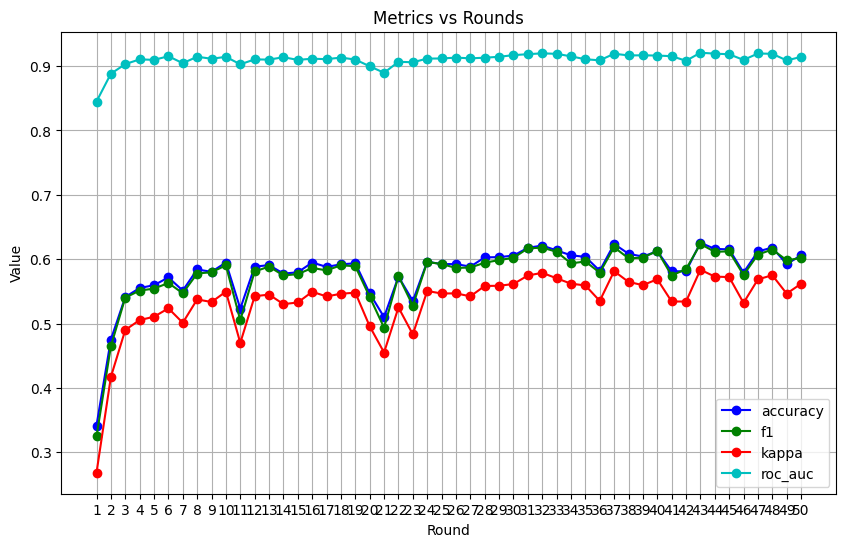

In [19]:

# def plot_metric(metric_data, metric_name):
#     rounds = [entry[0] for entry in metric_data]
#     values = [entry[1] for entry in metric_data]

#     plt.plot(rounds, values, marker='o', label=metric_name)
#     plt.title(f'{metric_name} vs Rounds')
#     plt.xlabel('Round')
#     plt.ylabel(metric_name)
#     plt.xticks(rounds)
#     plt.grid(True)
#     plt.legend()
#     plt.show()

# # Assuming you have the metrics object as described
# metrics = {
#     'accuracy': [(1, 0.352), (2, 0.268), (3, 0.374), (4, 0.36), (5, 0.44), (6, 0.424)],
#     'f1': [(1, 0.3311399108203808), (2, 0.23415159052431644), (3, 0.3483199605379145), (4, 0.339744710301753), (5, 0.44275590077921934), (6, 0.39898940221239404)],
#     'kappa': [(1, 0.28002239930313266), (2, 0.18975998299824226), (3, 0.30807015682269345), (4, 0.28559947134360886), (5, 0.3787000630175651), (6, 0.35998293287821004)],
#     'roc_auc': [(1, float('nan')), (2, float('nan')), (3, float('nan')), (4, float('nan')), (5, float('nan')), (6, float('nan'))]
# }

# # Plot each metric
# for metric_name, metric_data in history.metrics_distributed.items():
#     plot_metric(metric_data, metric_name)
import matplotlib.pyplot as plt

def plot_metrics(x):
    plt.figure(figsize=(10, 6))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors
    color_index = 0

    for metric_name, metric_data in x:
        rounds = [entry[0] for entry in metric_data]
        values = [entry[1] for entry in metric_data]
        plt.plot(rounds, values, marker='o', label=metric_name, color=colors[color_index % len(colors)])
        color_index += 1

    plt.title('Metrics vs Rounds')
    plt.xlabel('Round')
    plt.ylabel('Value')
    plt.xticks(rounds)
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming you have the metrics object as described
metrics = {
    'accuracy': [(1, 0.352), (2, 0.268), (3, 0.374), (4, 0.36), (5, 0.44), (6, 0.424)],
    'f1': [(1, 0.3311399108203808), (2, 0.23415159052431644), (3, 0.3483199605379145), (4, 0.339744710301753), (5, 0.44275590077921934), (6, 0.39898940221239404)],
    'kappa': [(1, 0.28002239930313266), (2, 0.18975998299824226), (3, 0.30807015682269345), (4, 0.28559947134360886), (5, 0.3787000630175651), (6, 0.35998293287821004)],
    'roc_auc': [(1, float('nan')), (2, float('nan')), (3, float('nan')), (4, float('nan')), (5, float('nan')), (6, float('nan'))]
}

plot_metrics(history.metrics_distributed.items())


to optimize and make things more optimized for the current resource :
we optimize the Model parameter modification to just the last 3 layers

In [ ]:
def FrozenNet():
    net=VGG('VGG16')

    #Freeze all layers
    for param in net.parameters():
        param.requires_grad = False

    #Unfreeze only the last 3 layers
    for param in list(net.parameters())[-3:]:
        param.requires_grad = True

    return net